this notebook looks at the fonv metric results for baseline/weather variants vs two different kind of simulations, chimera and bespoke.

In [1]:
import os
import numpy as np
import yaml
import pickle
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')

/lscratch/humna/ipykernel_1228016/115119132.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### load in config

In [3]:
config_path = '../scripts/config.yml'
config = yaml.safe_load(open(config_path, 'r'))

outdir = config['outdir']
basepath = config['basepath']
tag_to_look_for = config['tag_to_look_for']

timepts = config['timepts']
time_points = np.arange(timepts[0], timepts[1], timepts[2])
del timepts

### lets first see whats sims we have

In [4]:
for cat in ['baseline', 'weather']:
    dbpath = f'{basepath}/{cat}'
    print([f for f in os.listdir(dbpath) if f.endswith(tag_to_look_for)])

['baseline_v4.3.1_10yrs.db']
['weather_cloudso18v4.3.1_10yrs.db', 'weather_cloudso10v4.3.1_10yrs.db', 'weather_cloudso2v4.3.1_10yrs.db', 'weather_cloudso30v4.3.1_10yrs.db', 'weather_cloudso12v4.3.1_10yrs.db', 'weather_cloudso6v4.3.1_10yrs.db', 'weather_cloudso35v4.3.1_10yrs.db', 'weather_cloudso1v4.3.1_10yrs.db', 'weather_cloudso0v4.3.1_10yrs.db', 'weather_cloudso4v4.3.1_10yrs.db', 'weather_cloudso16v4.3.1_10yrs.db', 'weather_cloudso31v4.3.1_10yrs.db', 'weather_cloudso20v4.3.1_10yrs.db', 'weather_cloudso36v4.3.1_10yrs.db']


lets add some tags for helpful idenitification of the various sims

### read in the metrics data

In [5]:
fonvs_base = f'{outdir}/metrics/fonvs_vector_base.pickle'

out = pickle.load(open(fonvs_base, 'rb'))
fonvs_time_all, fonvs_time_per_filter = out['fonvs_time_all'], out['fonvs_time_per_filter']

## plot

In [6]:
baseline_tag = None
clouds_tag = {}
ints = []
for db in fonvs_time_all:
    if db.__contains__('baseline'):
        baseline_tag = db
    else:
        clouds_tag[db] = int(db.split('cloudso')[-1].split('v')[0])

clouds_tag = {k: v for k, v in sorted(clouds_tag.items(), key=lambda item: item[1], reverse=False)}

<Figure size 640x480 with 0 Axes>

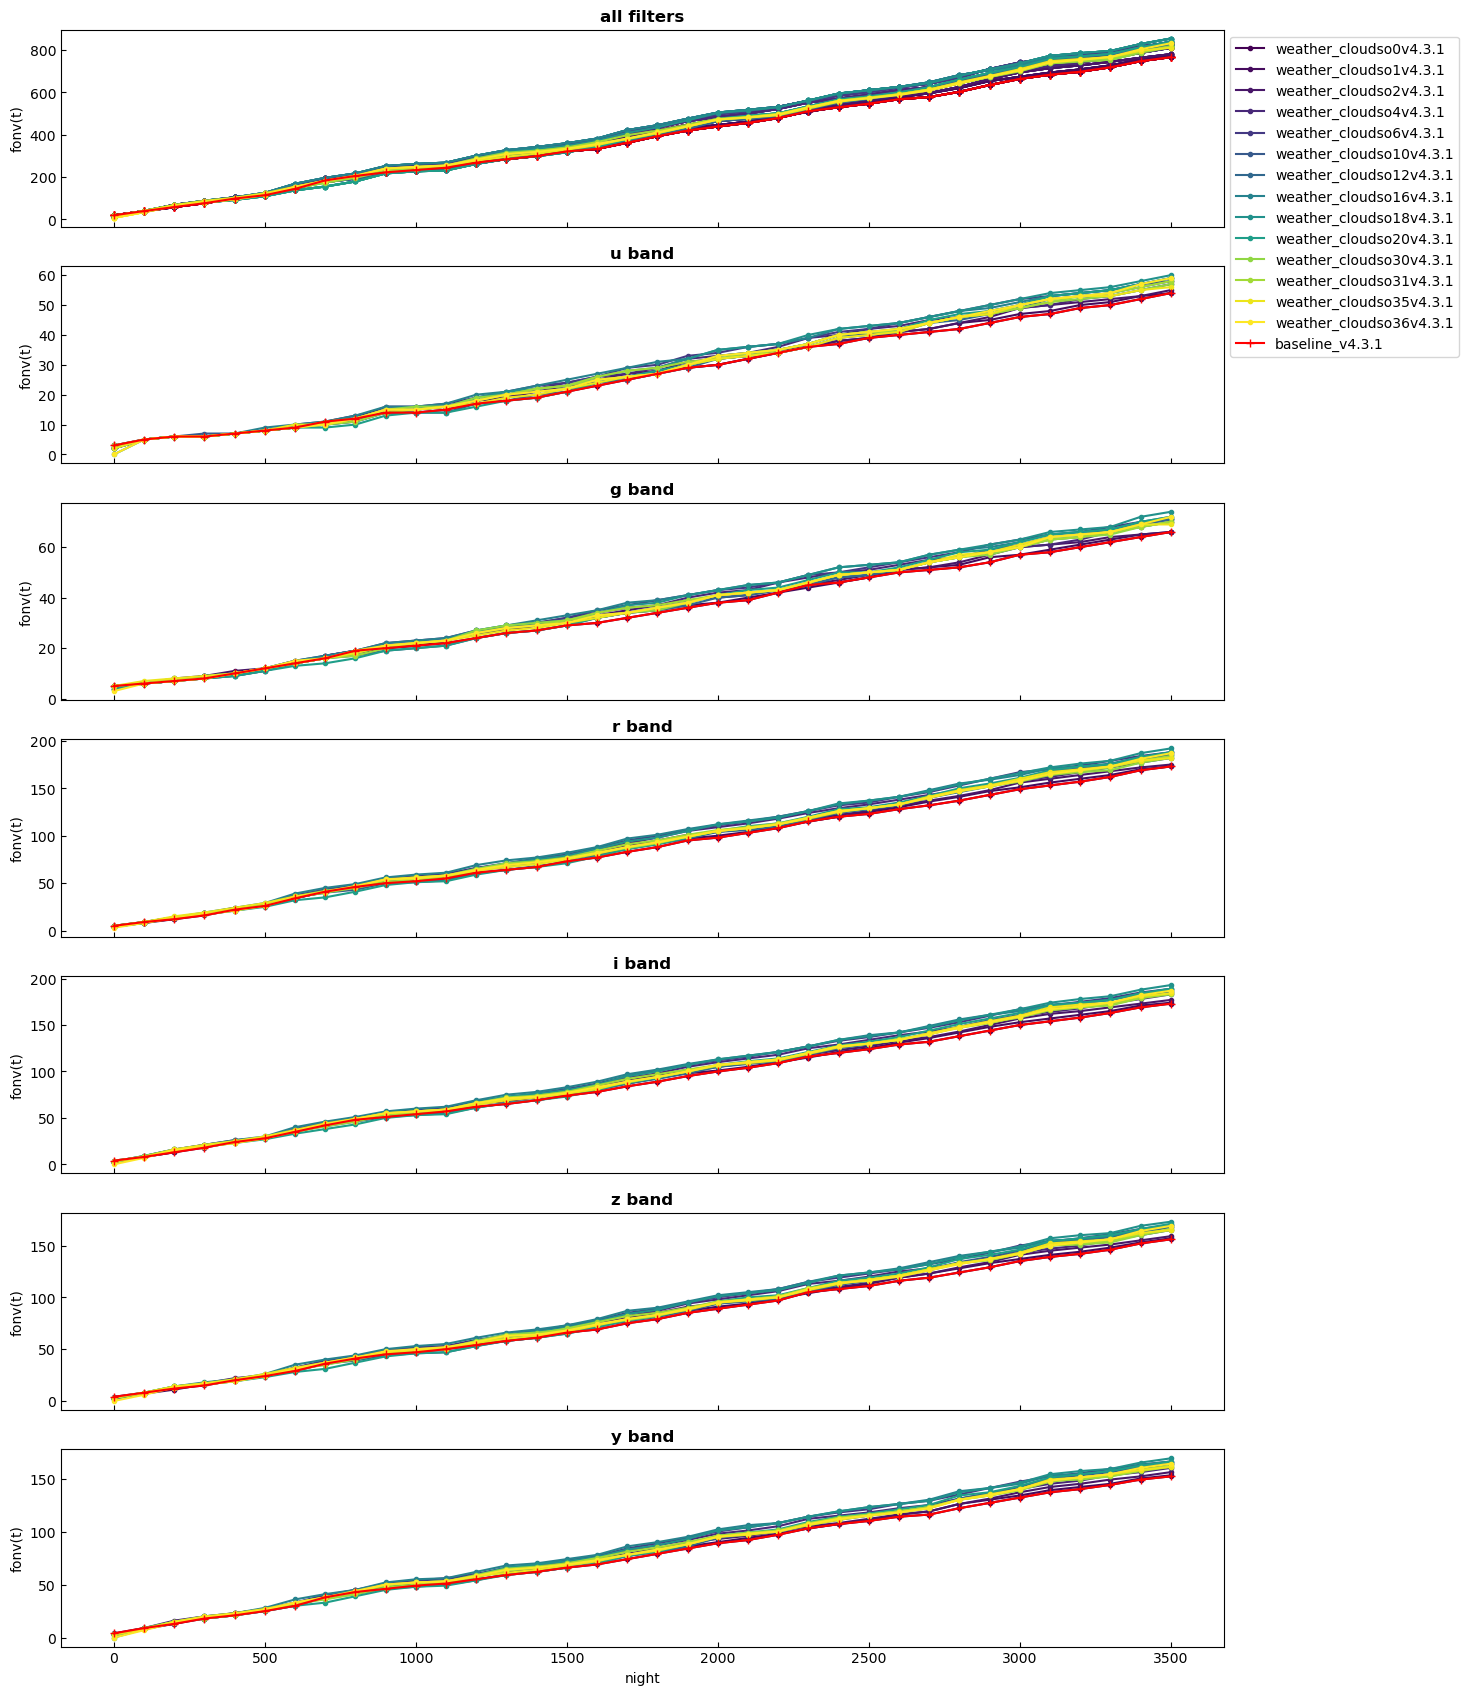

In [7]:
nrows, ncols = 7, 1

plt.clf()
fig, axes = plt.subplots(nrows, ncols)

for i, filt in enumerate(fonvs_time_per_filter):
    for j, db in enumerate(list(clouds_tag.keys()) + [baseline_tag]):
        if db.__contains__('baseline'):
            color = 'r'
            sym = '+'
        else:
            sym = '.'
            color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
        axes[0].plot(time_points[:-1], fonvs_time_all[db], sym+'-', label=db if i == 0 else None, color=color)
        axes[i+1].plot(time_points[:-1], fonvs_time_per_filter[filt][db], sym+'-', color=color)

        if j == 0:
            axes[0].set_title('all filters', fontweight='bold')
            axes[i+1].set_title(f'{filt} band', fontweight='bold')
            
for k in range(nrows):
    axes[k].tick_params(axis="both", direction="in")
    axes[k].set_ylabel('fonv(t)')
for k in range(nrows-1):
    axes[k].set_xticklabels([])

axes[0].legend(bbox_to_anchor=(1,1))
axes[-1].set_xlabel('night')

fig.set_size_inches(15, nrows*3)
plt.show()

ok not the most helpful plot .. lets plot the differences from baseline.

<Figure size 640x480 with 0 Axes>

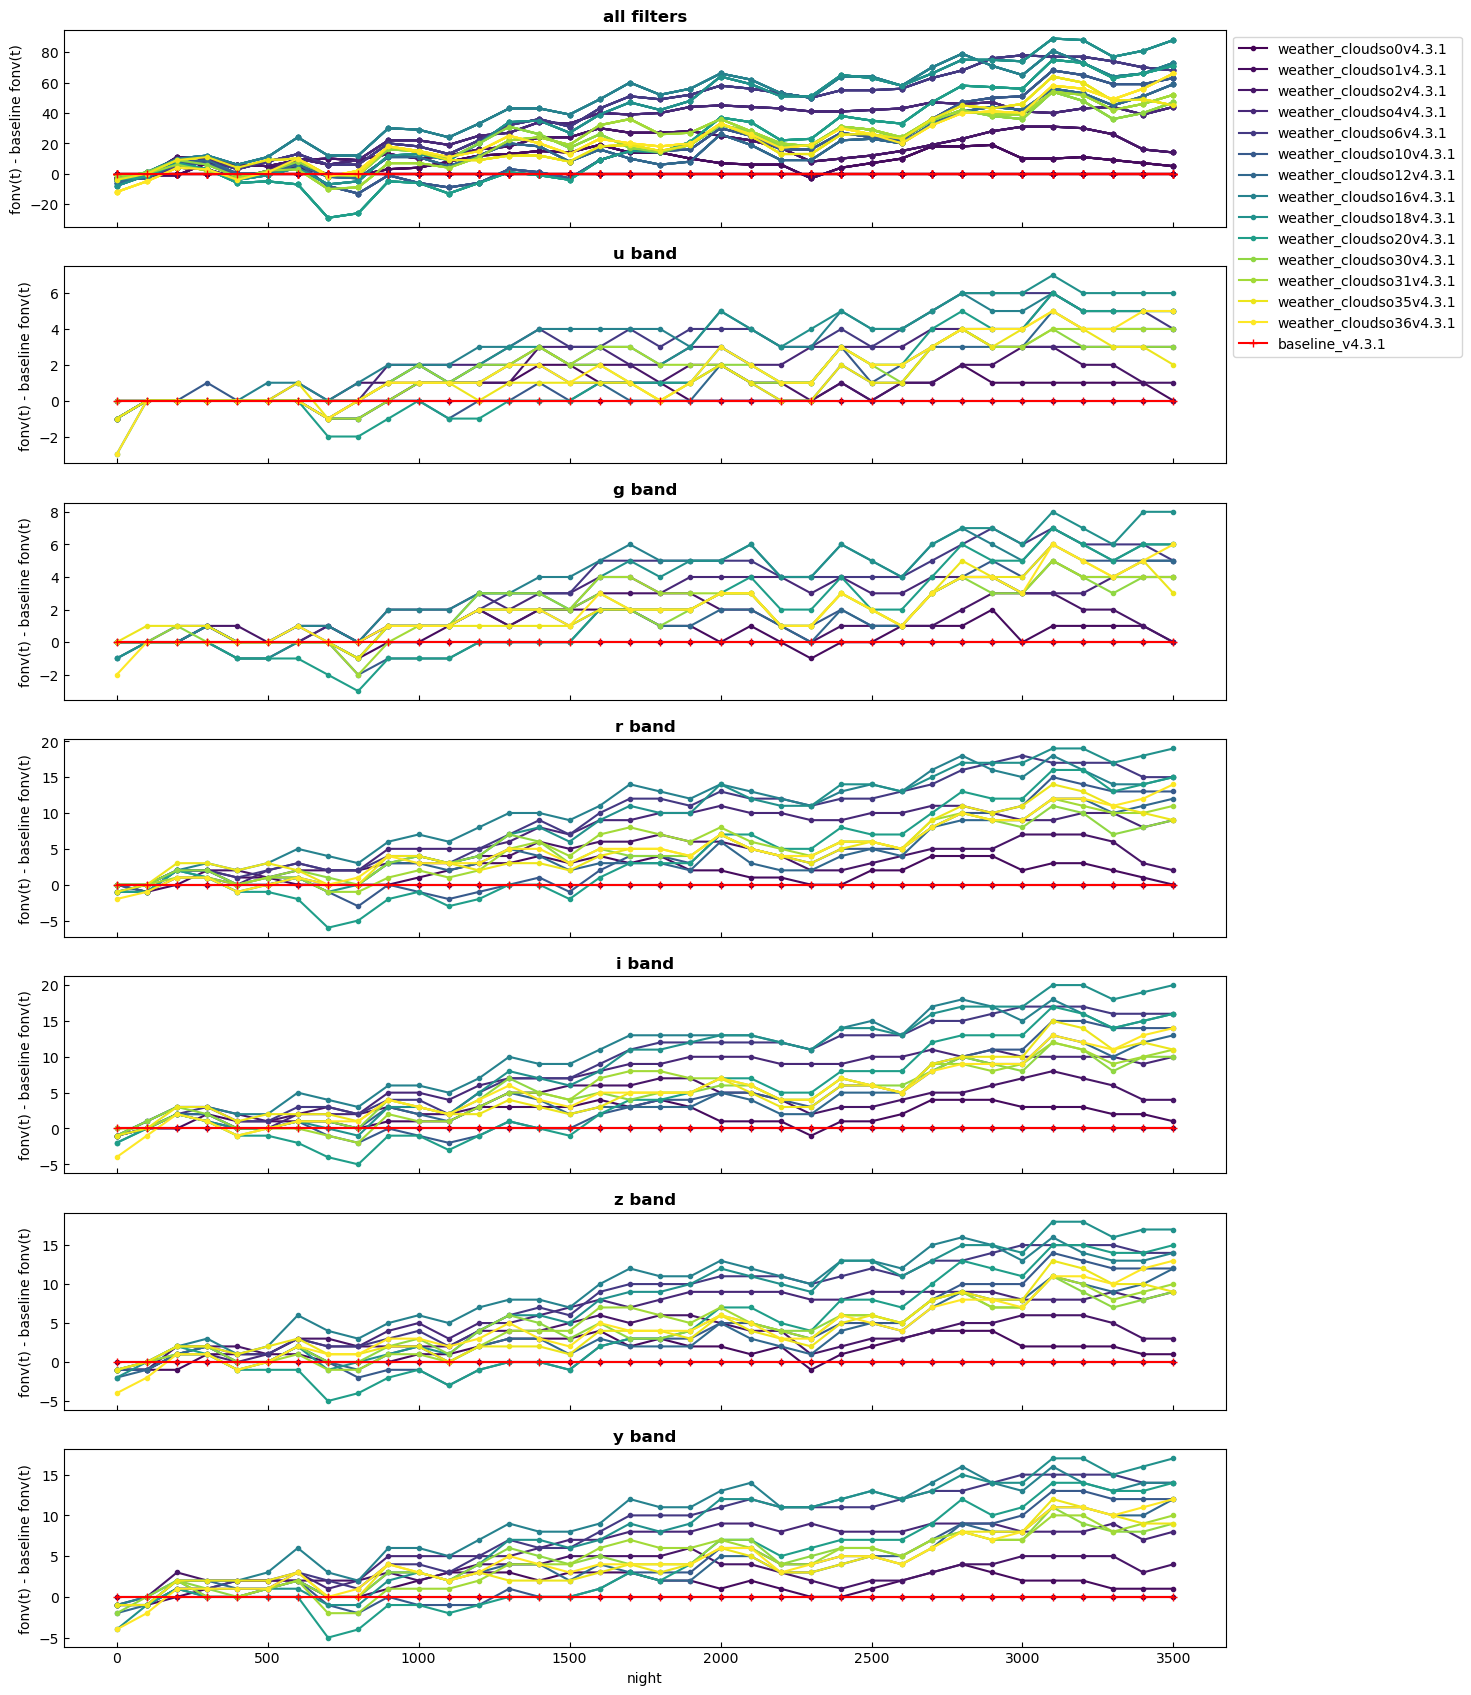

In [8]:
nrows, ncols = 7, 1

plt.clf()
fig, axes = plt.subplots(nrows, ncols)

for i, filt in enumerate(fonvs_time_per_filter):
    for j, db in enumerate(list(clouds_tag.keys()) + [baseline_tag]):
        if db.__contains__('baseline'):
            color = 'r'
            sym = '+'
        else:
            color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
            sym = '.'
        
        axes[0].plot(time_points[:-1], fonvs_time_all[db] - fonvs_time_all[baseline_tag], sym+'-', label=db if i == 0 else None, color=color)
        axes[i+1].plot(time_points[:-1], fonvs_time_per_filter[filt][db] - fonvs_time_per_filter[filt][baseline_tag], sym+'-', color=color)

        if j == 0:
            axes[0].set_title('all filters', fontweight='bold')
            axes[i+1].set_title(f'{filt} band', fontweight='bold')
            
for k in range(nrows):
    axes[k].tick_params(axis="both", direction="in")
    axes[k].set_ylabel('fonv(t) - baseline fonv(t)')
for k in range(nrows-1):
    axes[k].set_xticklabels([])

axes[0].legend(bbox_to_anchor=(1,1))
axes[-1].set_xlabel('night')

fig.set_size_inches(15, nrows*3)
plt.show()

ok we see a modest variation. naviely one would think that cloud tag number increase would linearly correlate with the metric - but it doesnt. something to understand more and investigate.

## chimera sims

les add metric results from chimera (using the `--chimera` option in `run.py`). these sims keep a given weather simulation up to a certain point (`cutoff_date`) after which the visits are straight from baseline.

In [9]:
chimera_fonvs_time_all, chimera_fonvs_time_per_filter = {}, {}

for outfile in [f for f in os.listdir(f'{outdir}/metrics') if f.startswith('fonvs_vector_chimera_cutoff')]:
    # read in
    chimera_metrics = f'{outdir}/metrics/{outfile}'

    cutoff = outfile.split('cutoff')[-1].split('.pickle')[0]
    
    out = pickle.load(open(chimera_metrics, 'rb'))
    chimera_fonvs_time_all[cutoff], chimera_fonvs_time_per_filter[cutoff] = out['chimera_fonvs_time_all'], out['chimera_fonvs_time_per_filter']

lets also find the night number at which things should change in our plots

In [10]:
import pandas as pd
import sqlite3
from astropy.time import Time
import astropy.units as u

conn = sqlite3.connect('/sdf/data/rubin/shared/fbs_sims/sims_longterm_tests//baseline/baseline_v4.3.1_10yrs.db')
query = f"select * from observations limit 1"
df = pd.read_sql(query, conn)
conn.close()

start = Time(df['observationStartMJD'].min(), format='mjd')

cutoff_night = {}
for cutoff in chimera_fonvs_time_all:
    cutoff_obj =  Time(cutoff, format='isot')
    
    cutoff_night[cutoff] = (cutoff_obj - start).to(u.day).value # is this correct? need to think if we should be rounding up/down
    print(f'## nights between start {start.isot[0:10]} and cutoff {cutoff}: {cutoff_night[cutoff] }')

## nights between start 2025-11-01 and cutoff 2026-03-01: 119.99841812172235
## nights between start 2025-11-01 and cutoff 2028-09-01: 1034.9984181217224


now lets plot

<Figure size 640x480 with 0 Axes>

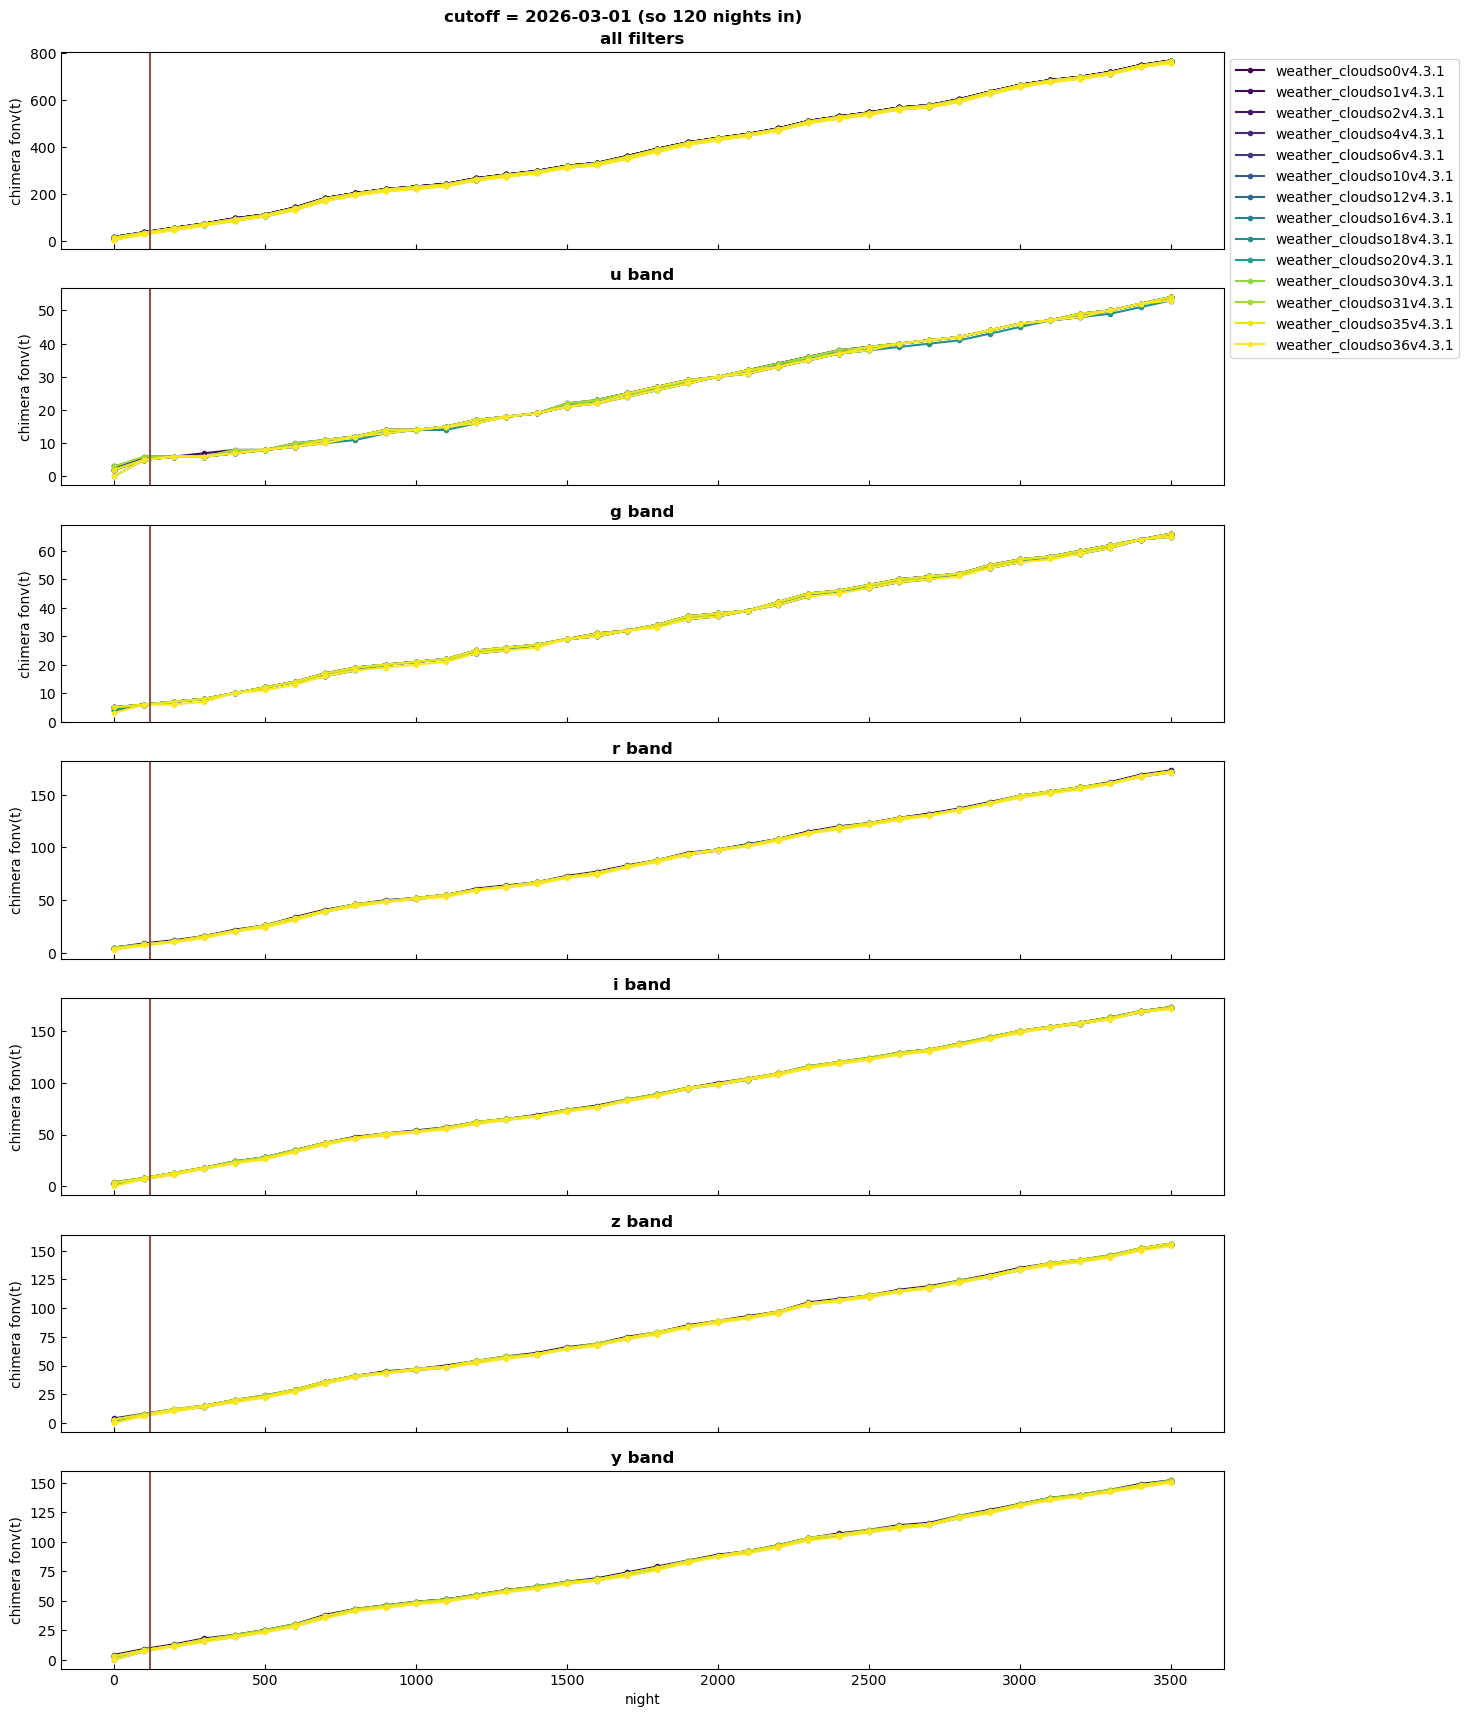

<Figure size 640x480 with 0 Axes>

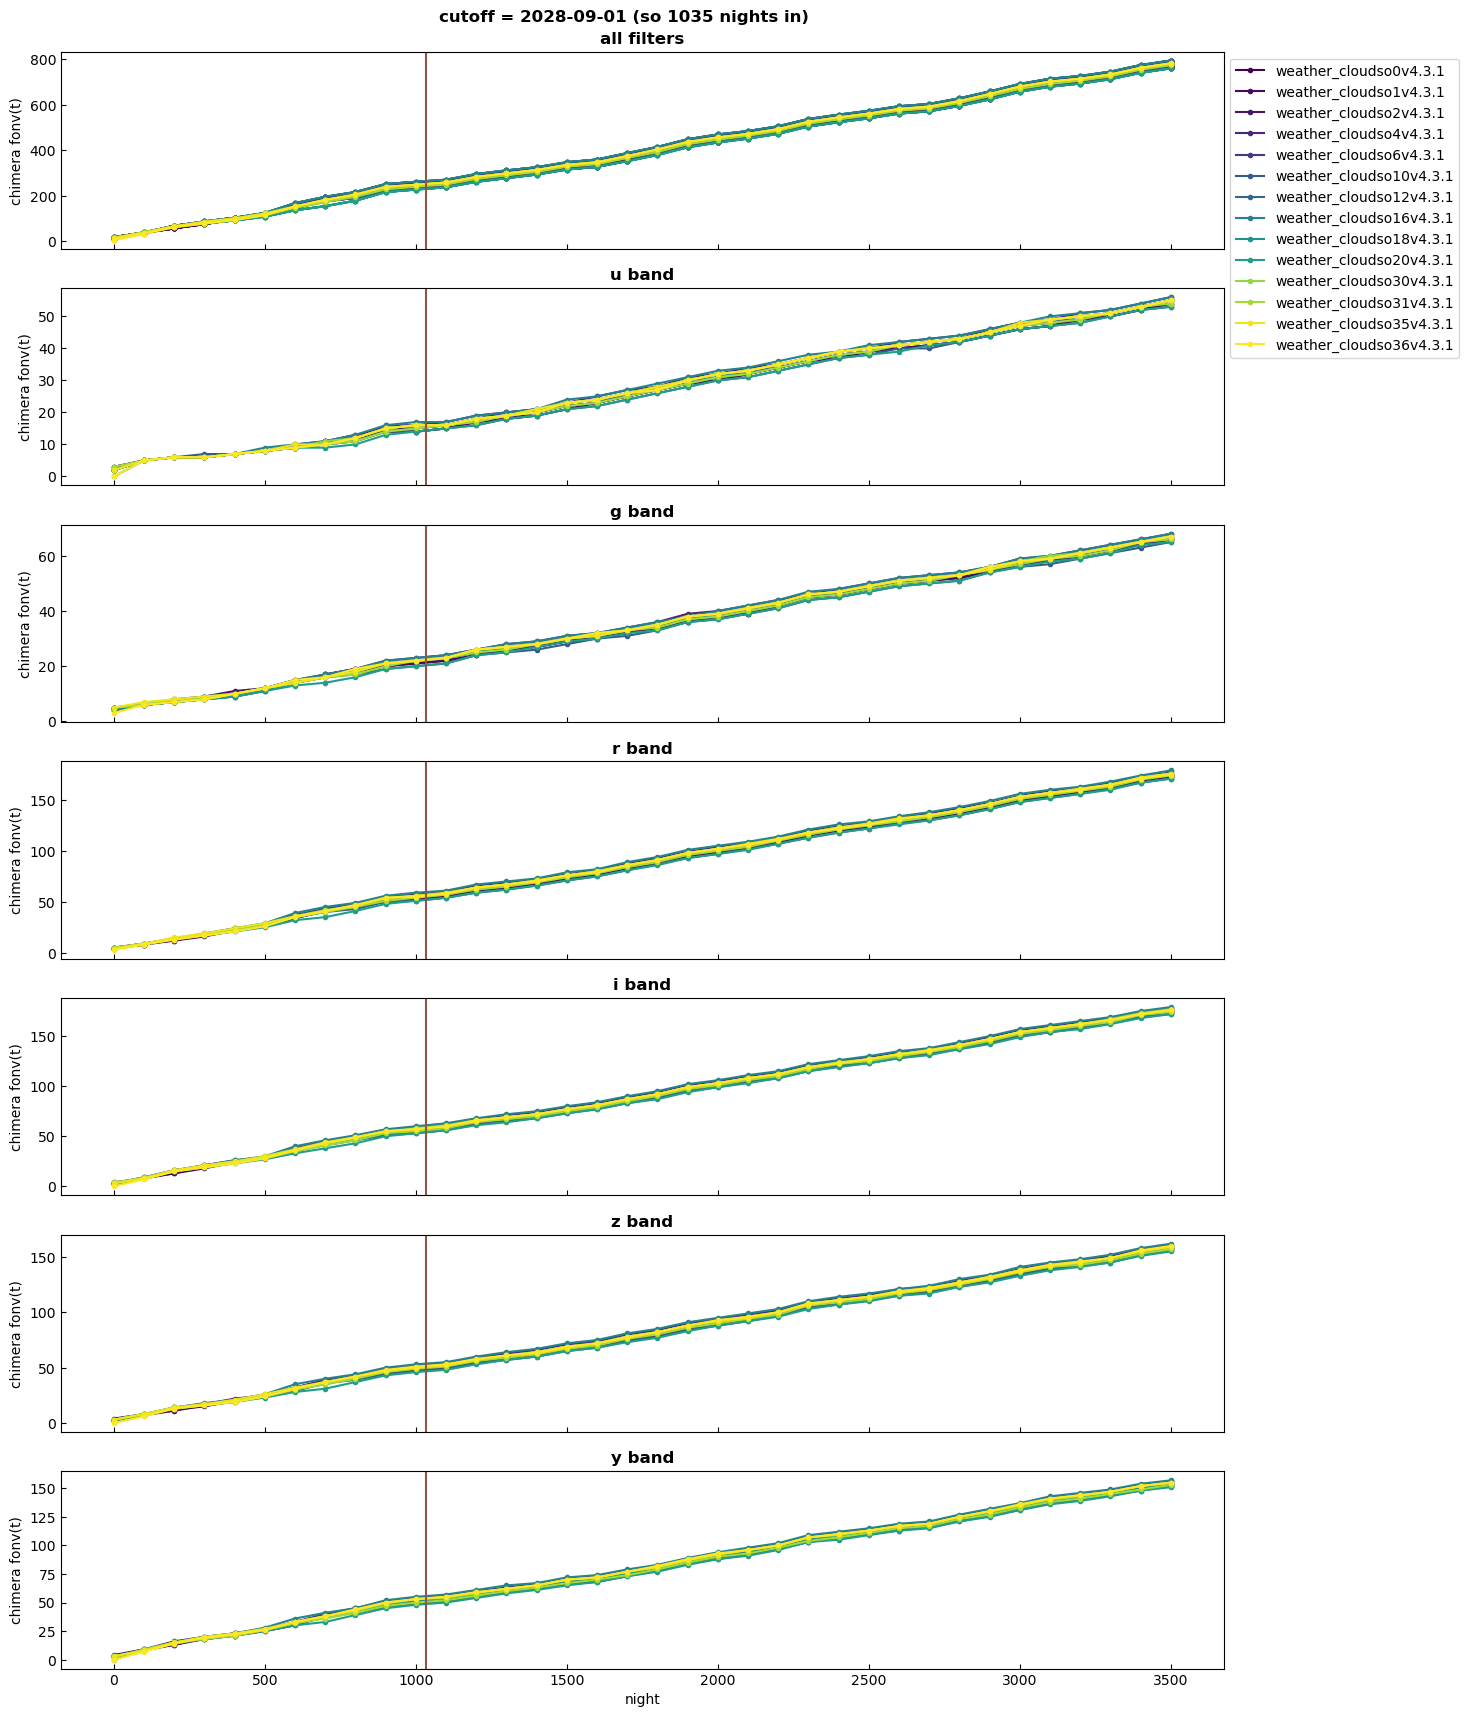

In [11]:
nrows, ncols = 7, 1

for cutoff in chimera_fonvs_time_all:
    plt.clf()
    fig, axes = plt.subplots(nrows, ncols)
    
    for i, filt in enumerate(chimera_fonvs_time_per_filter[cutoff]):
        for j, db in enumerate(list(clouds_tag.keys())):
            if db.__contains__('baseline'):
                color = 'r'
                sym = '+'
            else:
                color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
                sym = '.'

            key = f'chimera_cutoff{cutoff}_{db}'
            axes[0].plot(time_points[:-1], chimera_fonvs_time_all[cutoff][key],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1].plot(time_points[:-1], chimera_fonvs_time_per_filter[cutoff][filt][key],
                            sym+'-', color=color)
    
            if j == 0:
                axes[0].set_title('all filters', fontweight='bold')
                axes[i+1].set_title(f'{filt} band', fontweight='bold')
                
    for k in range(nrows):
        axes[k].tick_params(axis="both", direction="in")
        axes[k].set_ylabel('chimera fonv(t)')
        ymin, ymax = axes[k].get_ylim()
        axes[k].axvline(cutoff_night[cutoff], ymin, ymax, color='C5', ls='-')
        
    for k in range(nrows-1):
        axes[k].set_xticklabels([])
    
    axes[0].legend(bbox_to_anchor=(1,1))
    axes[-1].set_xlabel('night')

    plt.suptitle(f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)', fontweight='bold', y=0.9)
    fig.set_size_inches(15, nrows*3)
    plt.show()

not very helpful - since we can see by eye what has changed. lets plot the differences between chimera and original sims.

<Figure size 640x480 with 0 Axes>

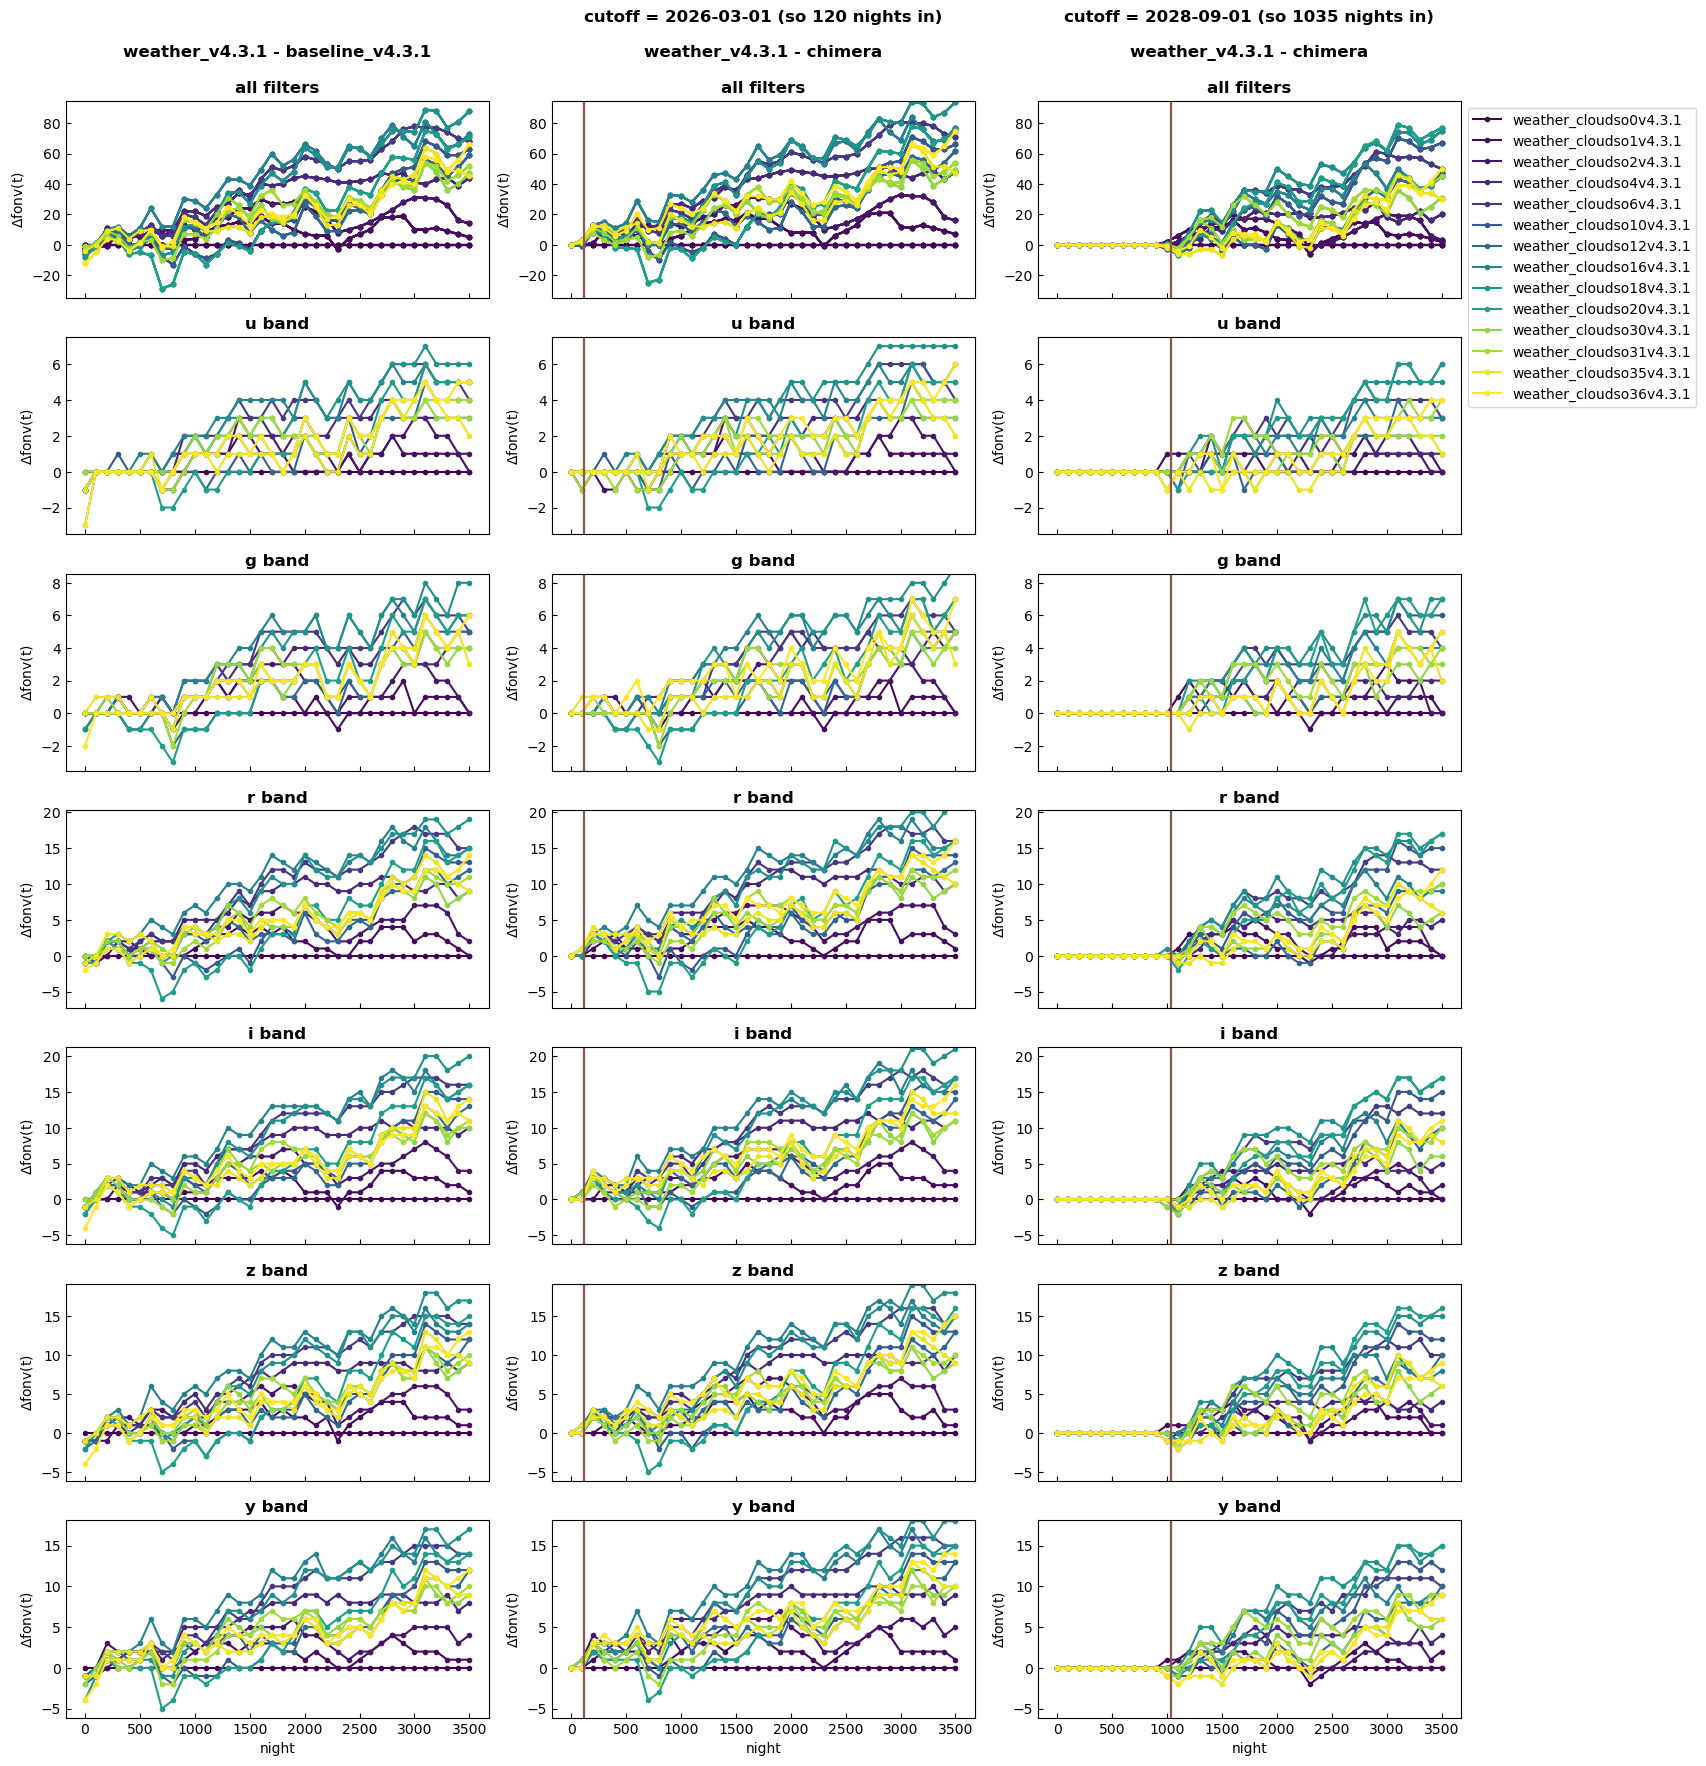

In [12]:
nrows, ncols = 7, 1+len(cutoff_night.keys())

plt.clf()
fig, axes = plt.subplots(nrows, ncols)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
for i, filt in enumerate(fonvs_time_per_filter):
    for j, db in enumerate(list(clouds_tag.keys())):
        if db.__contains__('baseline'):
            color = 'r'
            sym = '+'
        else:
            color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
            sym = '.'

        # original vs baseline
        axes[0, 0].plot(time_points[:-1], fonvs_time_all[db] - fonvs_time_all[baseline_tag], sym+'-',
                     label=db if i == 0 else None, color=color)
        axes[i+1, 0].plot(time_points[:-1], fonvs_time_per_filter[filt][db] - fonvs_time_per_filter[filt][baseline_tag],
                       sym+'-', color=color)
        for ci, cutoff in enumerate(chimera_fonvs_time_all):
            # original vs chimera
            key = f'chimera_cutoff{cutoff}_{db}'
            axes[0, ci+1].plot(time_points[:-1], fonvs_time_all[db] - chimera_fonvs_time_all[cutoff][key],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, ci+1].plot(time_points[:-1], fonvs_time_per_filter[filt][db] - chimera_fonvs_time_per_filter[cutoff][filt][key],
                            sym+'-', color=color)
            if j == 0:
                axes[0, ci+1].set_title( f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)\n\nweather_v4.3.1 - chimera\n\nall filters', fontweight='bold')

        if j == 0:
            axes[0, 0].set_title( f'weather_v4.3.1 - baseline_v4.3.1\n\nall filters', fontweight='bold')
            for col in range(ncols):
                
                axes[i+1, col].set_title(f'{filt} band', fontweight='bold')
                
for k in range(nrows):
    ylims = axes[k, 0].get_ylim()
    for c in range(ncols):
        axes[k, c].tick_params(axis="both", direction="in")
        axes[k, c].set_ylabel(r'$\Delta$fonv(t)')
        axes[k, c].set_ylim(ylims)
        for ci, cutoff in enumerate(cutoff_night):
            axes[k, ci+1].axvline(cutoff_night[cutoff], ymin, ymax, ls='-', color='C5')
    
for k in range(nrows-1):
    for c in range(ncols):
        axes[k, c].set_xticklabels([])

axes[0, -1].legend(bbox_to_anchor=(1,1))
for c in range(ncols):
    axes[-1, c].set_xlabel('night')

fig.set_size_inches(6*ncols, nrows*3)
plt.show()

ok so the trends are basically the same after the cutoff date - good, since this means that we are indeed appending the baseline - with the differences between original and chimera sims more apparent with a cutoff a bit further into the survey.

## bespoke sims

now lets add in the results from bespoke sims (generated `--bespoke-sim-only` and `bespoke-metrics` options in `run.py`). these sims keep a given weather simulation up to a certain point (`cutoff_date`) after which the visits are simulated using `sim_runner` with the baseline configuration.

In [13]:
bespoke_fonvs_time_all, bespoke_fonvs_time_per_filter = {}, {}

for outfile in [f for f in os.listdir(f'{outdir}/metrics') if f.startswith('fonvs_vector_bespoke_cutoff')]:
    # read in
    bespoke_metrics = f'{outdir}/metrics/{outfile}'

    cutoff = outfile.split('cutoff')[-1].split('.pickle')[0]
    
    out = pickle.load(open(bespoke_metrics, 'rb'))
    bespoke_fonvs_time_all[cutoff], bespoke_fonvs_time_per_filter[cutoff] = out['bespoke_fonvs_time_all'], out['bespoke_fonvs_time_per_filter']
# bespoke_fonvs_time_all

<Figure size 640x480 with 0 Axes>

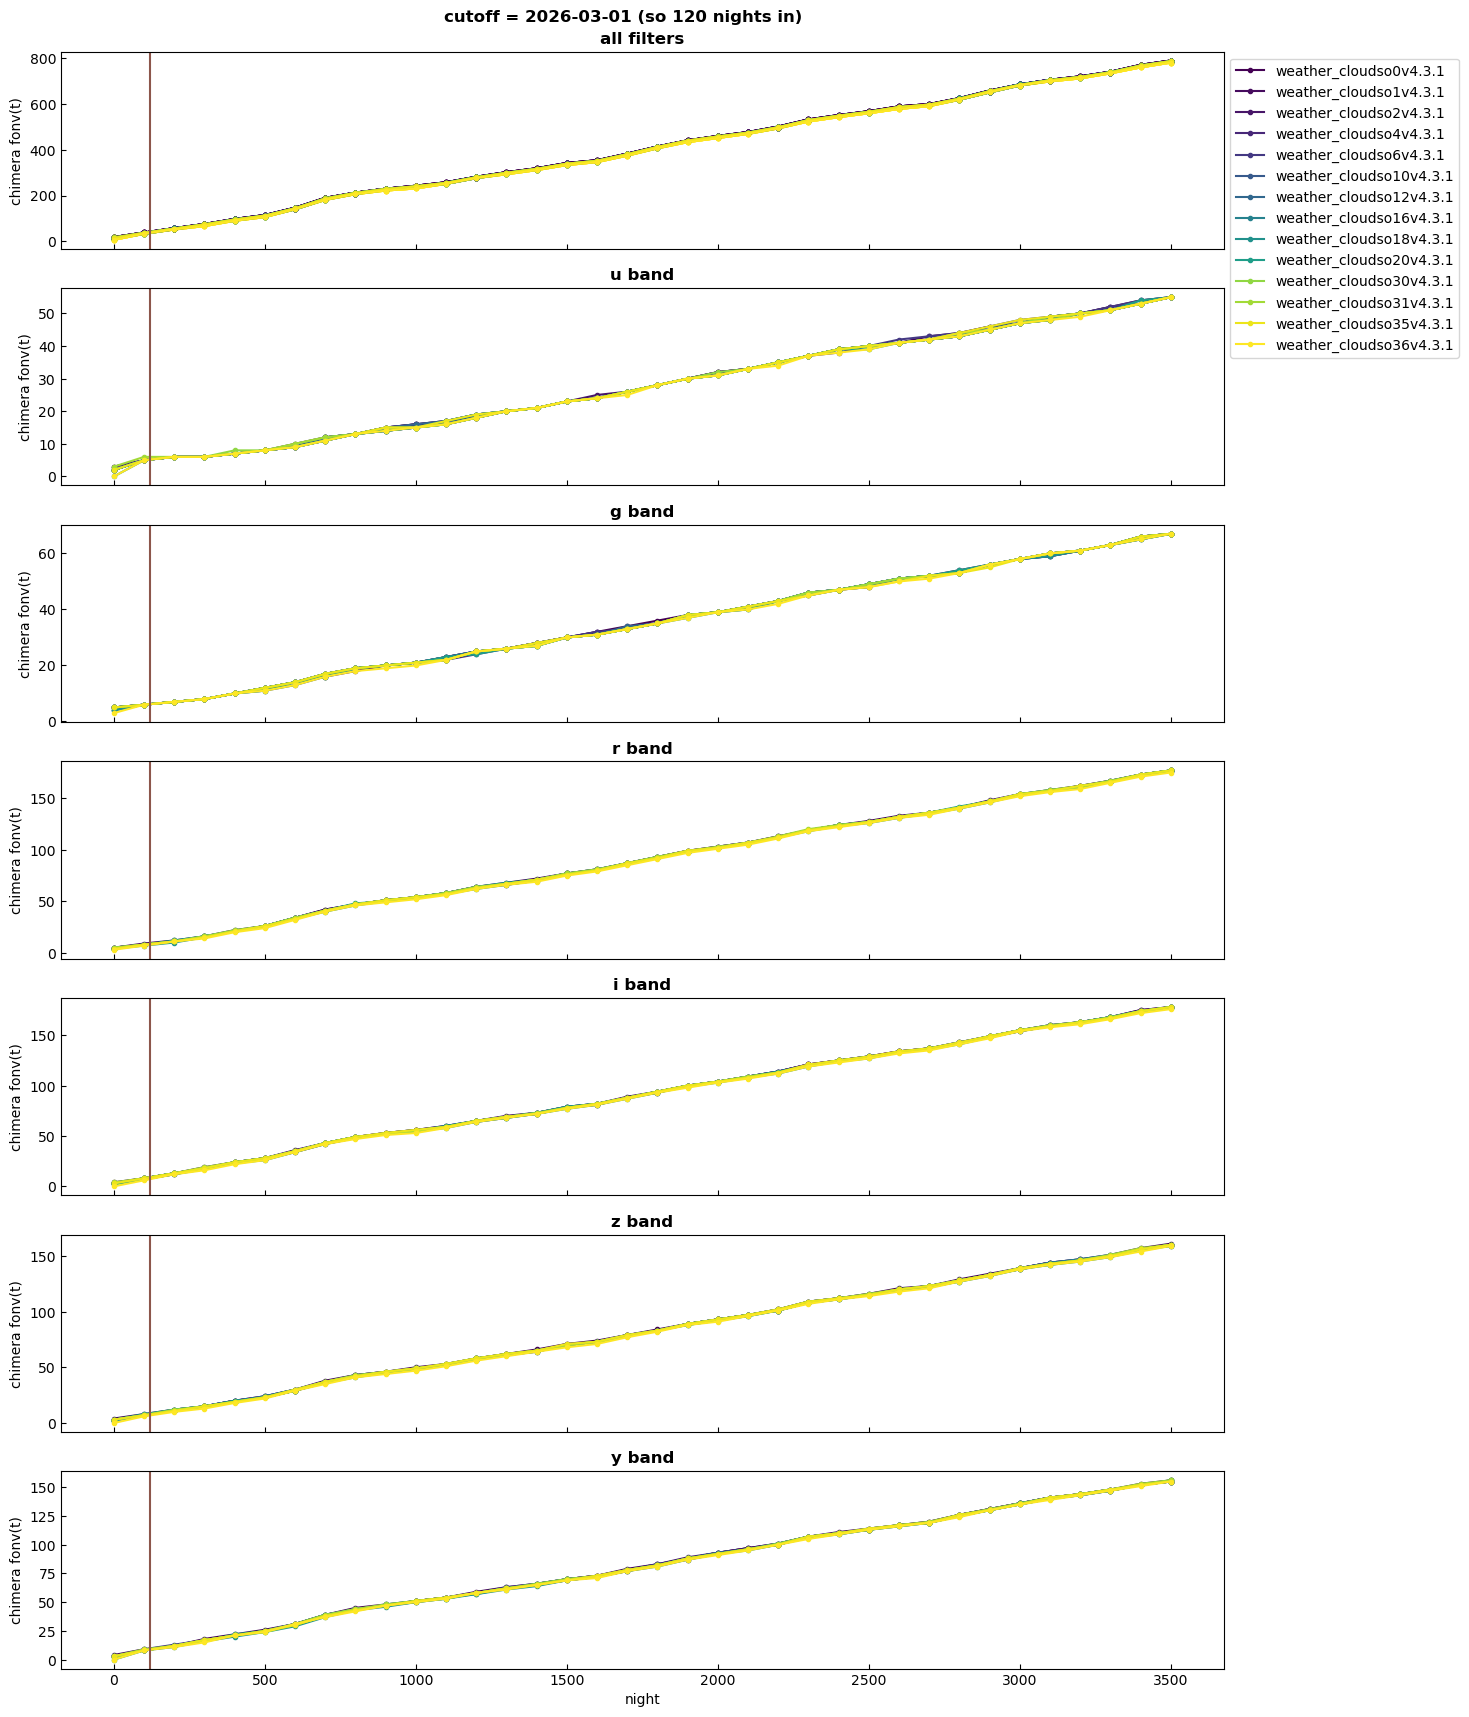

<Figure size 640x480 with 0 Axes>

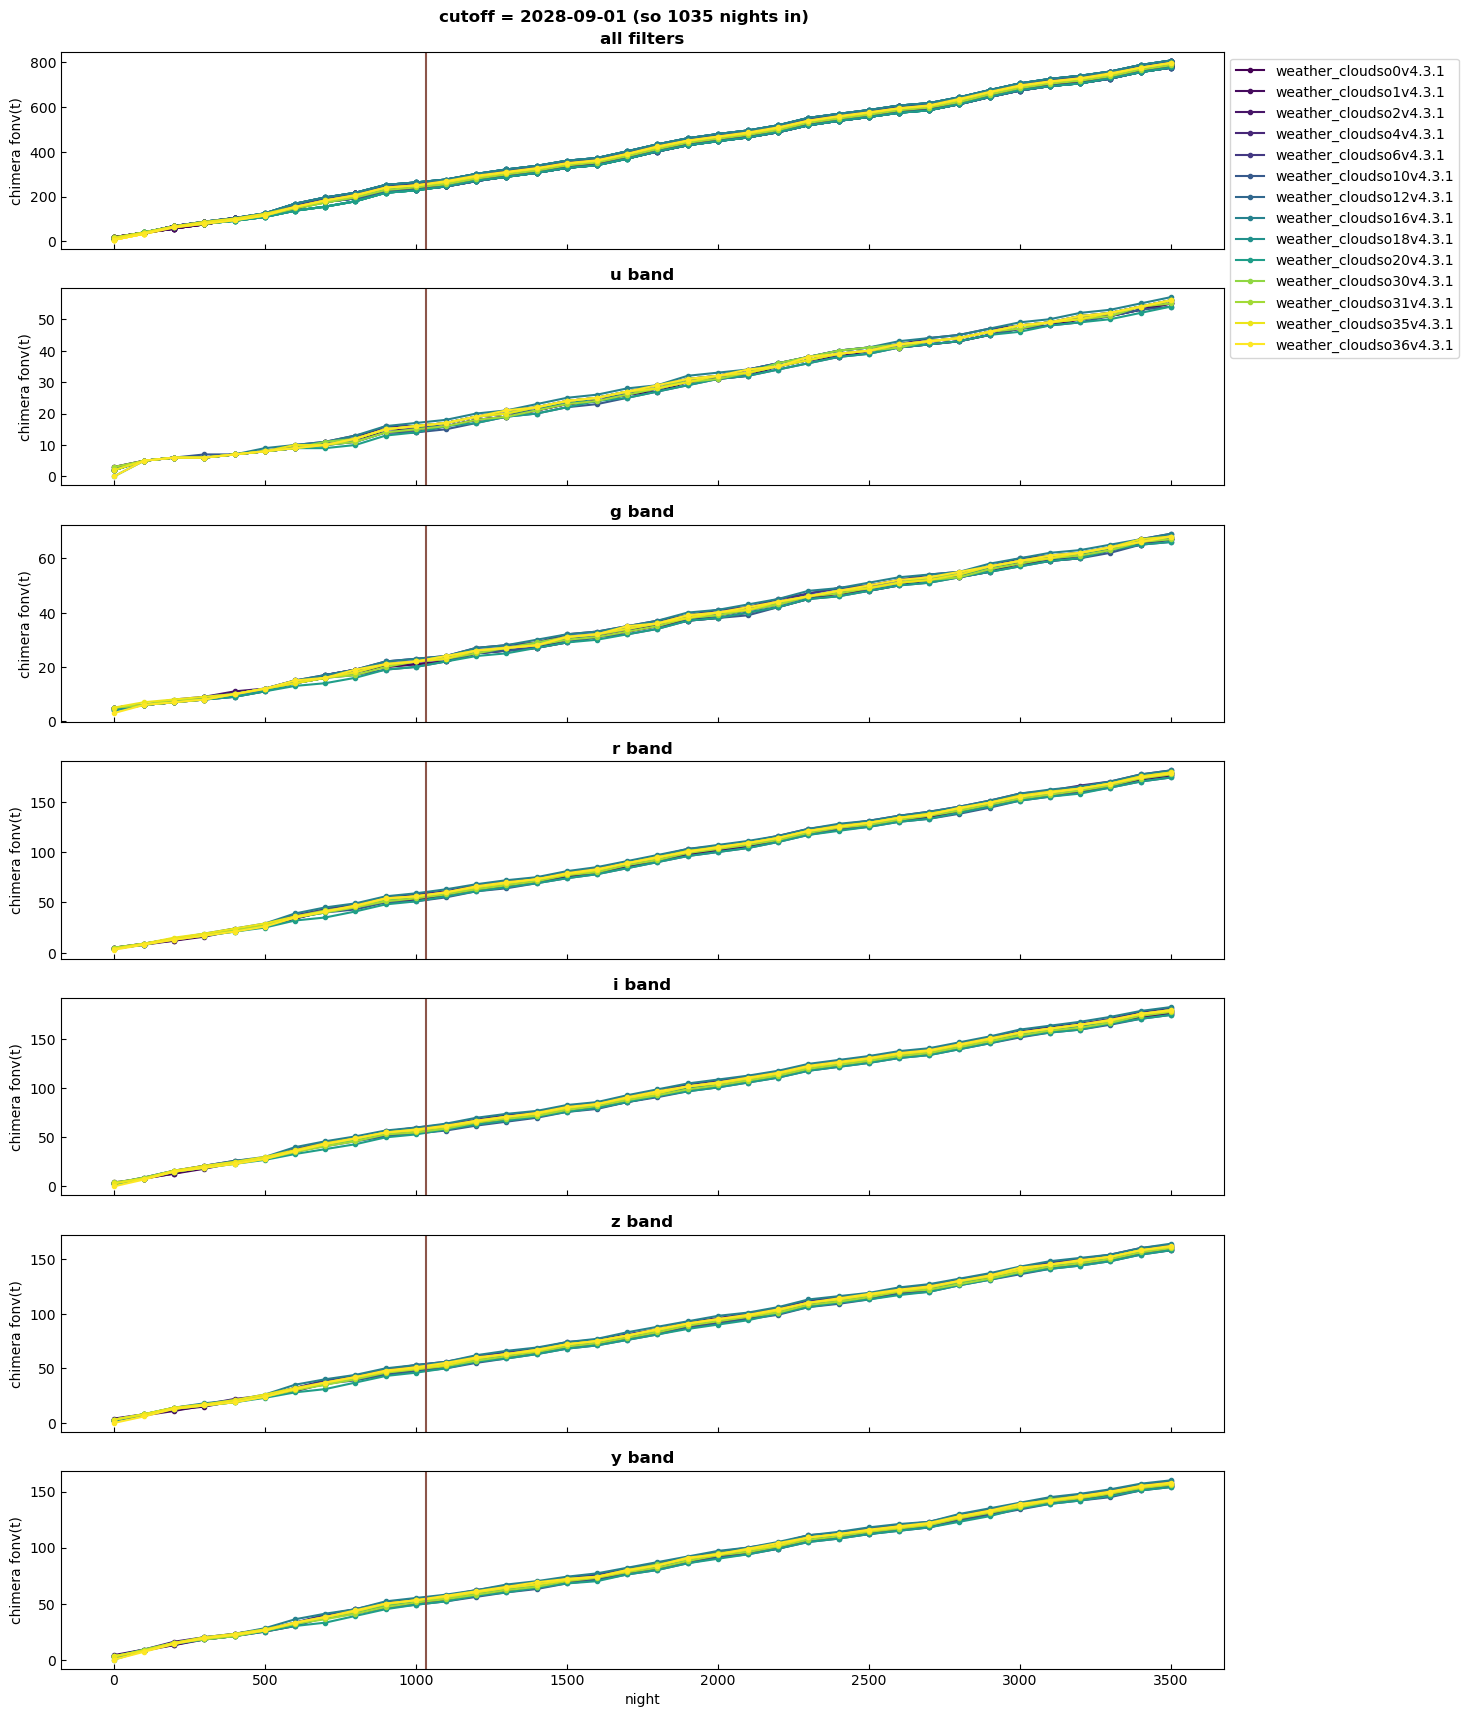

In [14]:
nrows, ncols = 7, 1
inds = None
for cutoff in chimera_fonvs_time_all:
    plt.clf()
    fig, axes = plt.subplots(nrows, ncols)
    
    for i, filt in enumerate(bespoke_fonvs_time_per_filter[cutoff]):
        for j, db in enumerate(list(clouds_tag.keys())):
            if db.__contains__('baseline'):
                color = 'r'
                sym = '+'
            else:
                color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
                sym = '.'

            key = f'bespoke_cutoff{cutoff}_{db}'
            axes[0].plot(time_points[:-1], bespoke_fonvs_time_all[cutoff][key],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1].plot(time_points[:-1], bespoke_fonvs_time_per_filter[cutoff][filt][key],
                            sym+'-', color=color)
    
            if j == 0:
                axes[0].set_title('all filters', fontweight='bold')
                axes[i+1].set_title(f'{filt} band', fontweight='bold')
                
    for k in range(nrows):
        axes[k].tick_params(axis="both", direction="in")
        axes[k].set_ylabel('chimera fonv(t)')
        ymin, ymax = axes[k].get_ylim()
        axes[k].axvline(cutoff_night[cutoff], ymin, ymax, color='C5', ls='-')
        
    for k in range(nrows-1):
        axes[k].set_xticklabels([])
    
    axes[0].legend(bbox_to_anchor=(1,1))
    axes[-1].set_xlabel('night')

    plt.suptitle(f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)', fontweight='bold', y=0.9)
    fig.set_size_inches(15, nrows*3)
    plt.show()

as above, these are not the most helpful plots - but at least good to know that we dont have any weird discontinuities. lets plot the differences, as we did for chimera. we'll create separate plots for the two cutoff dates.

<Figure size 640x480 with 0 Axes>

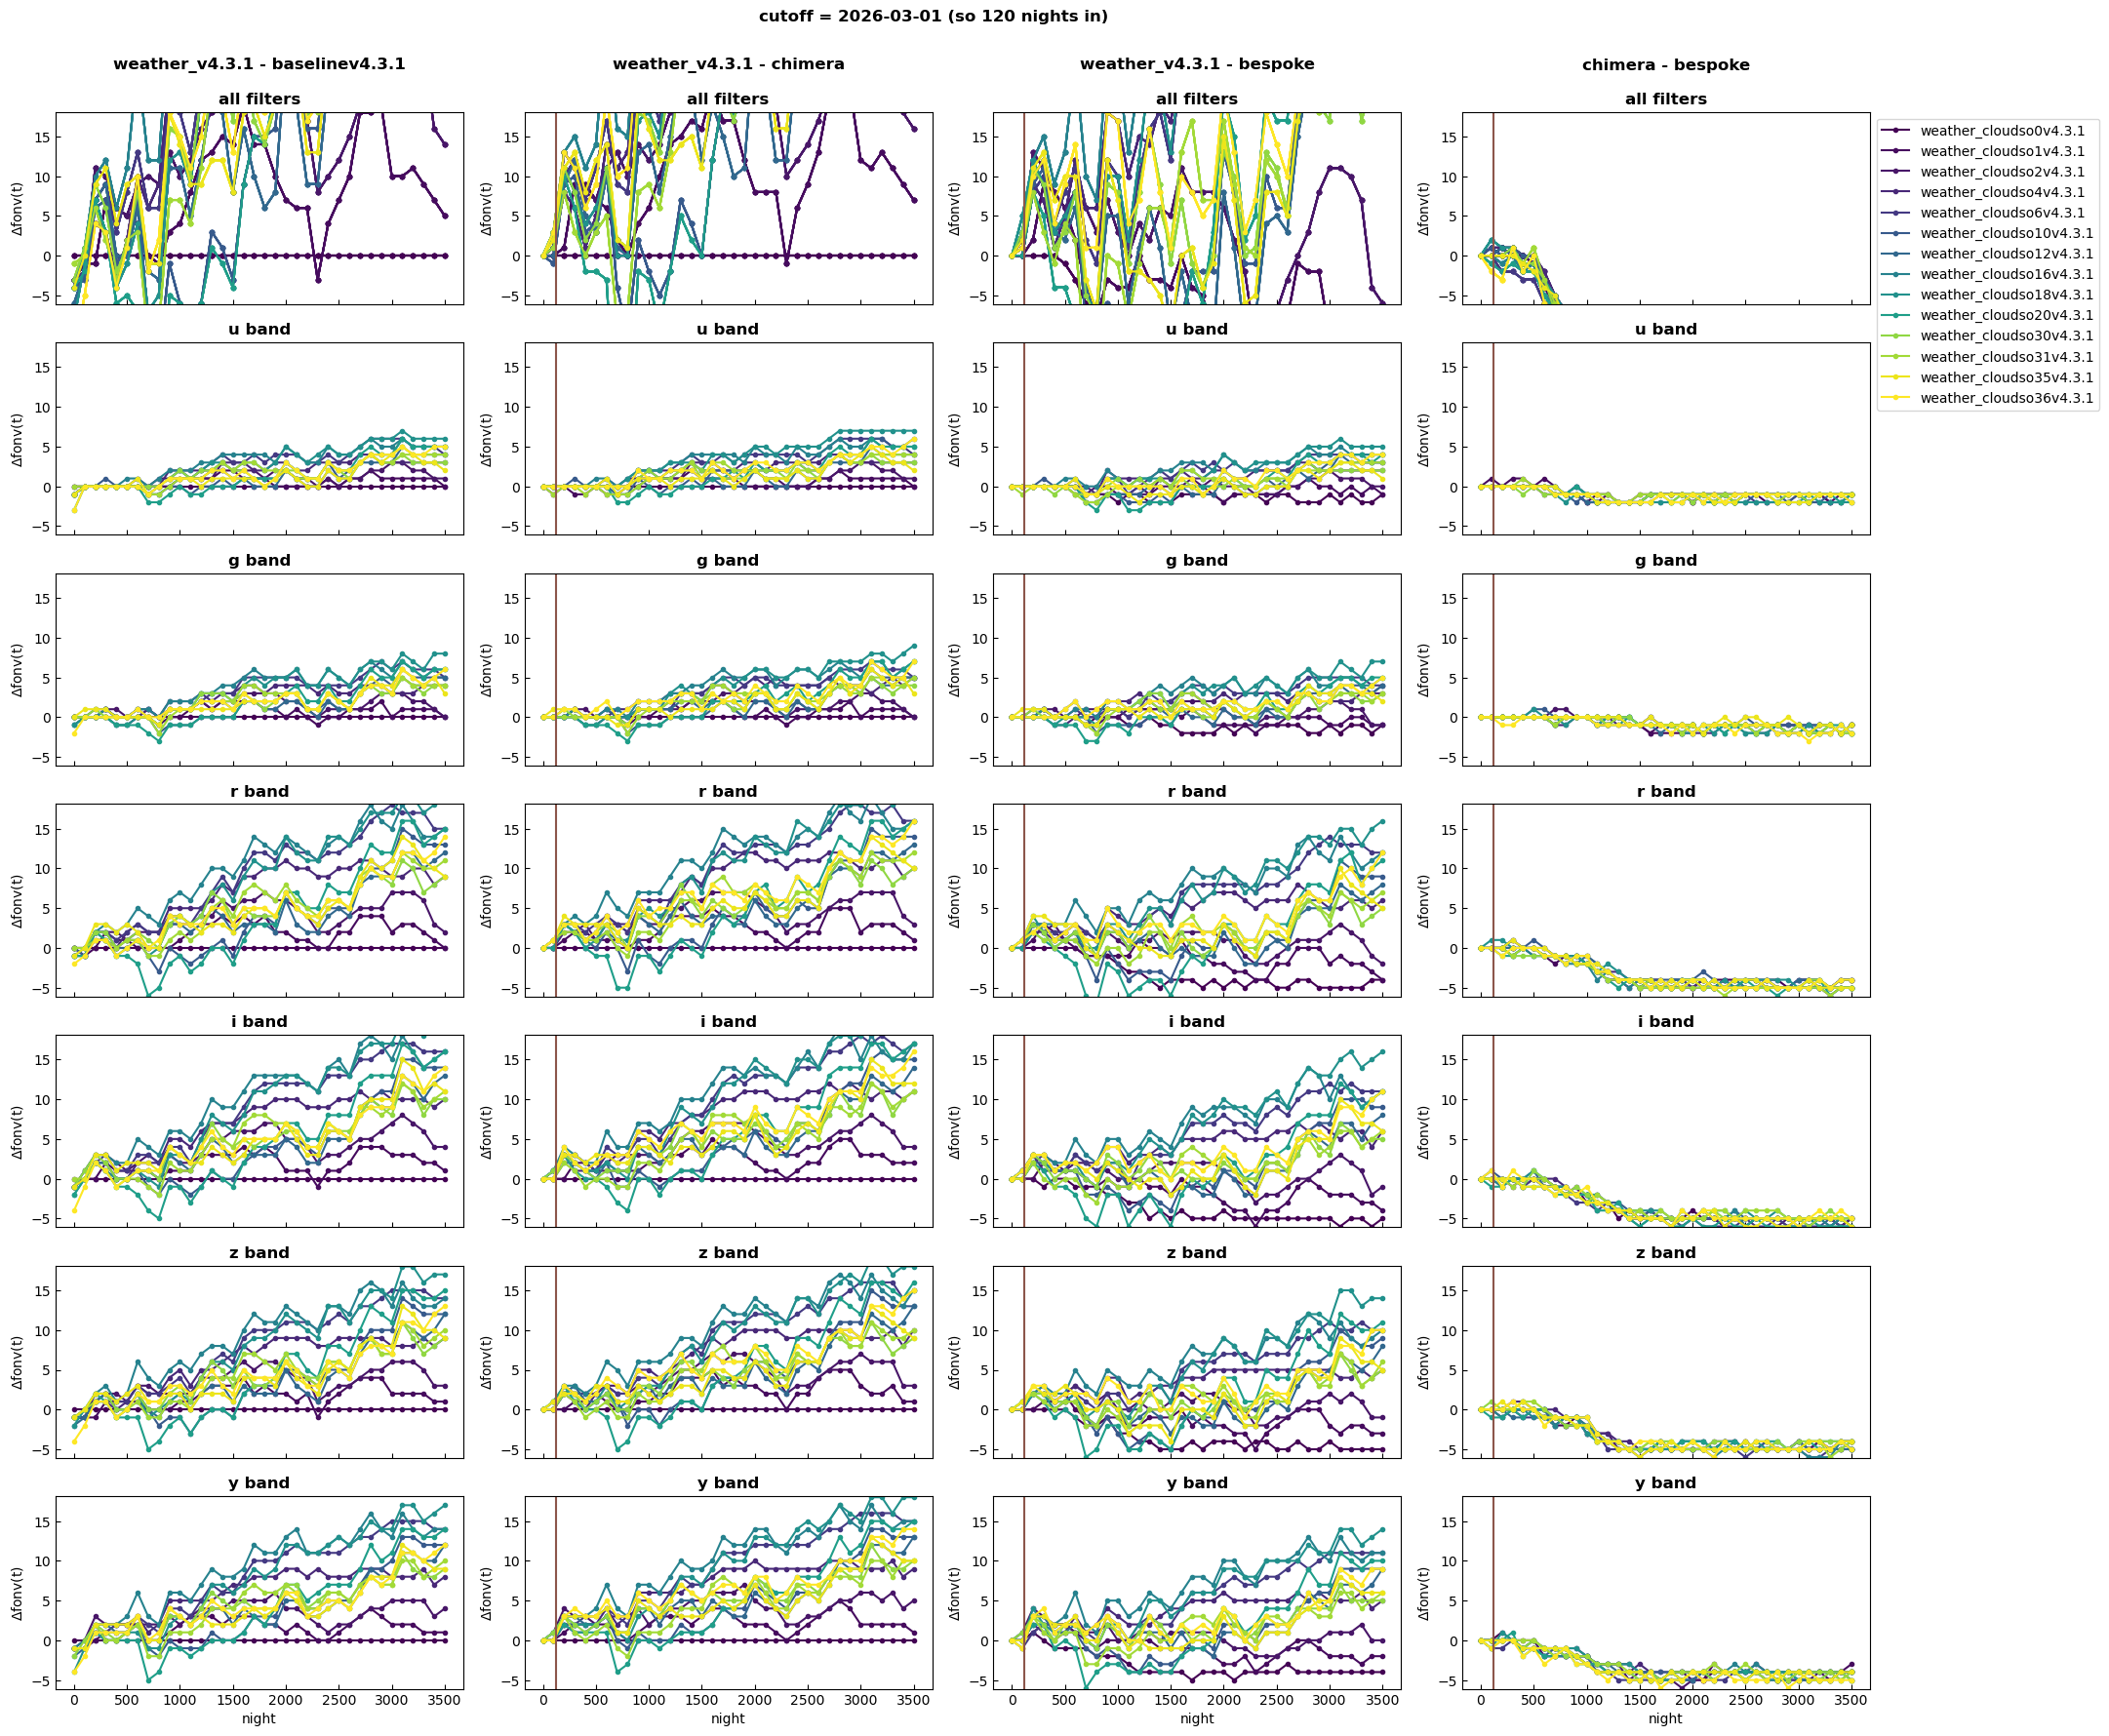

<Figure size 640x480 with 0 Axes>

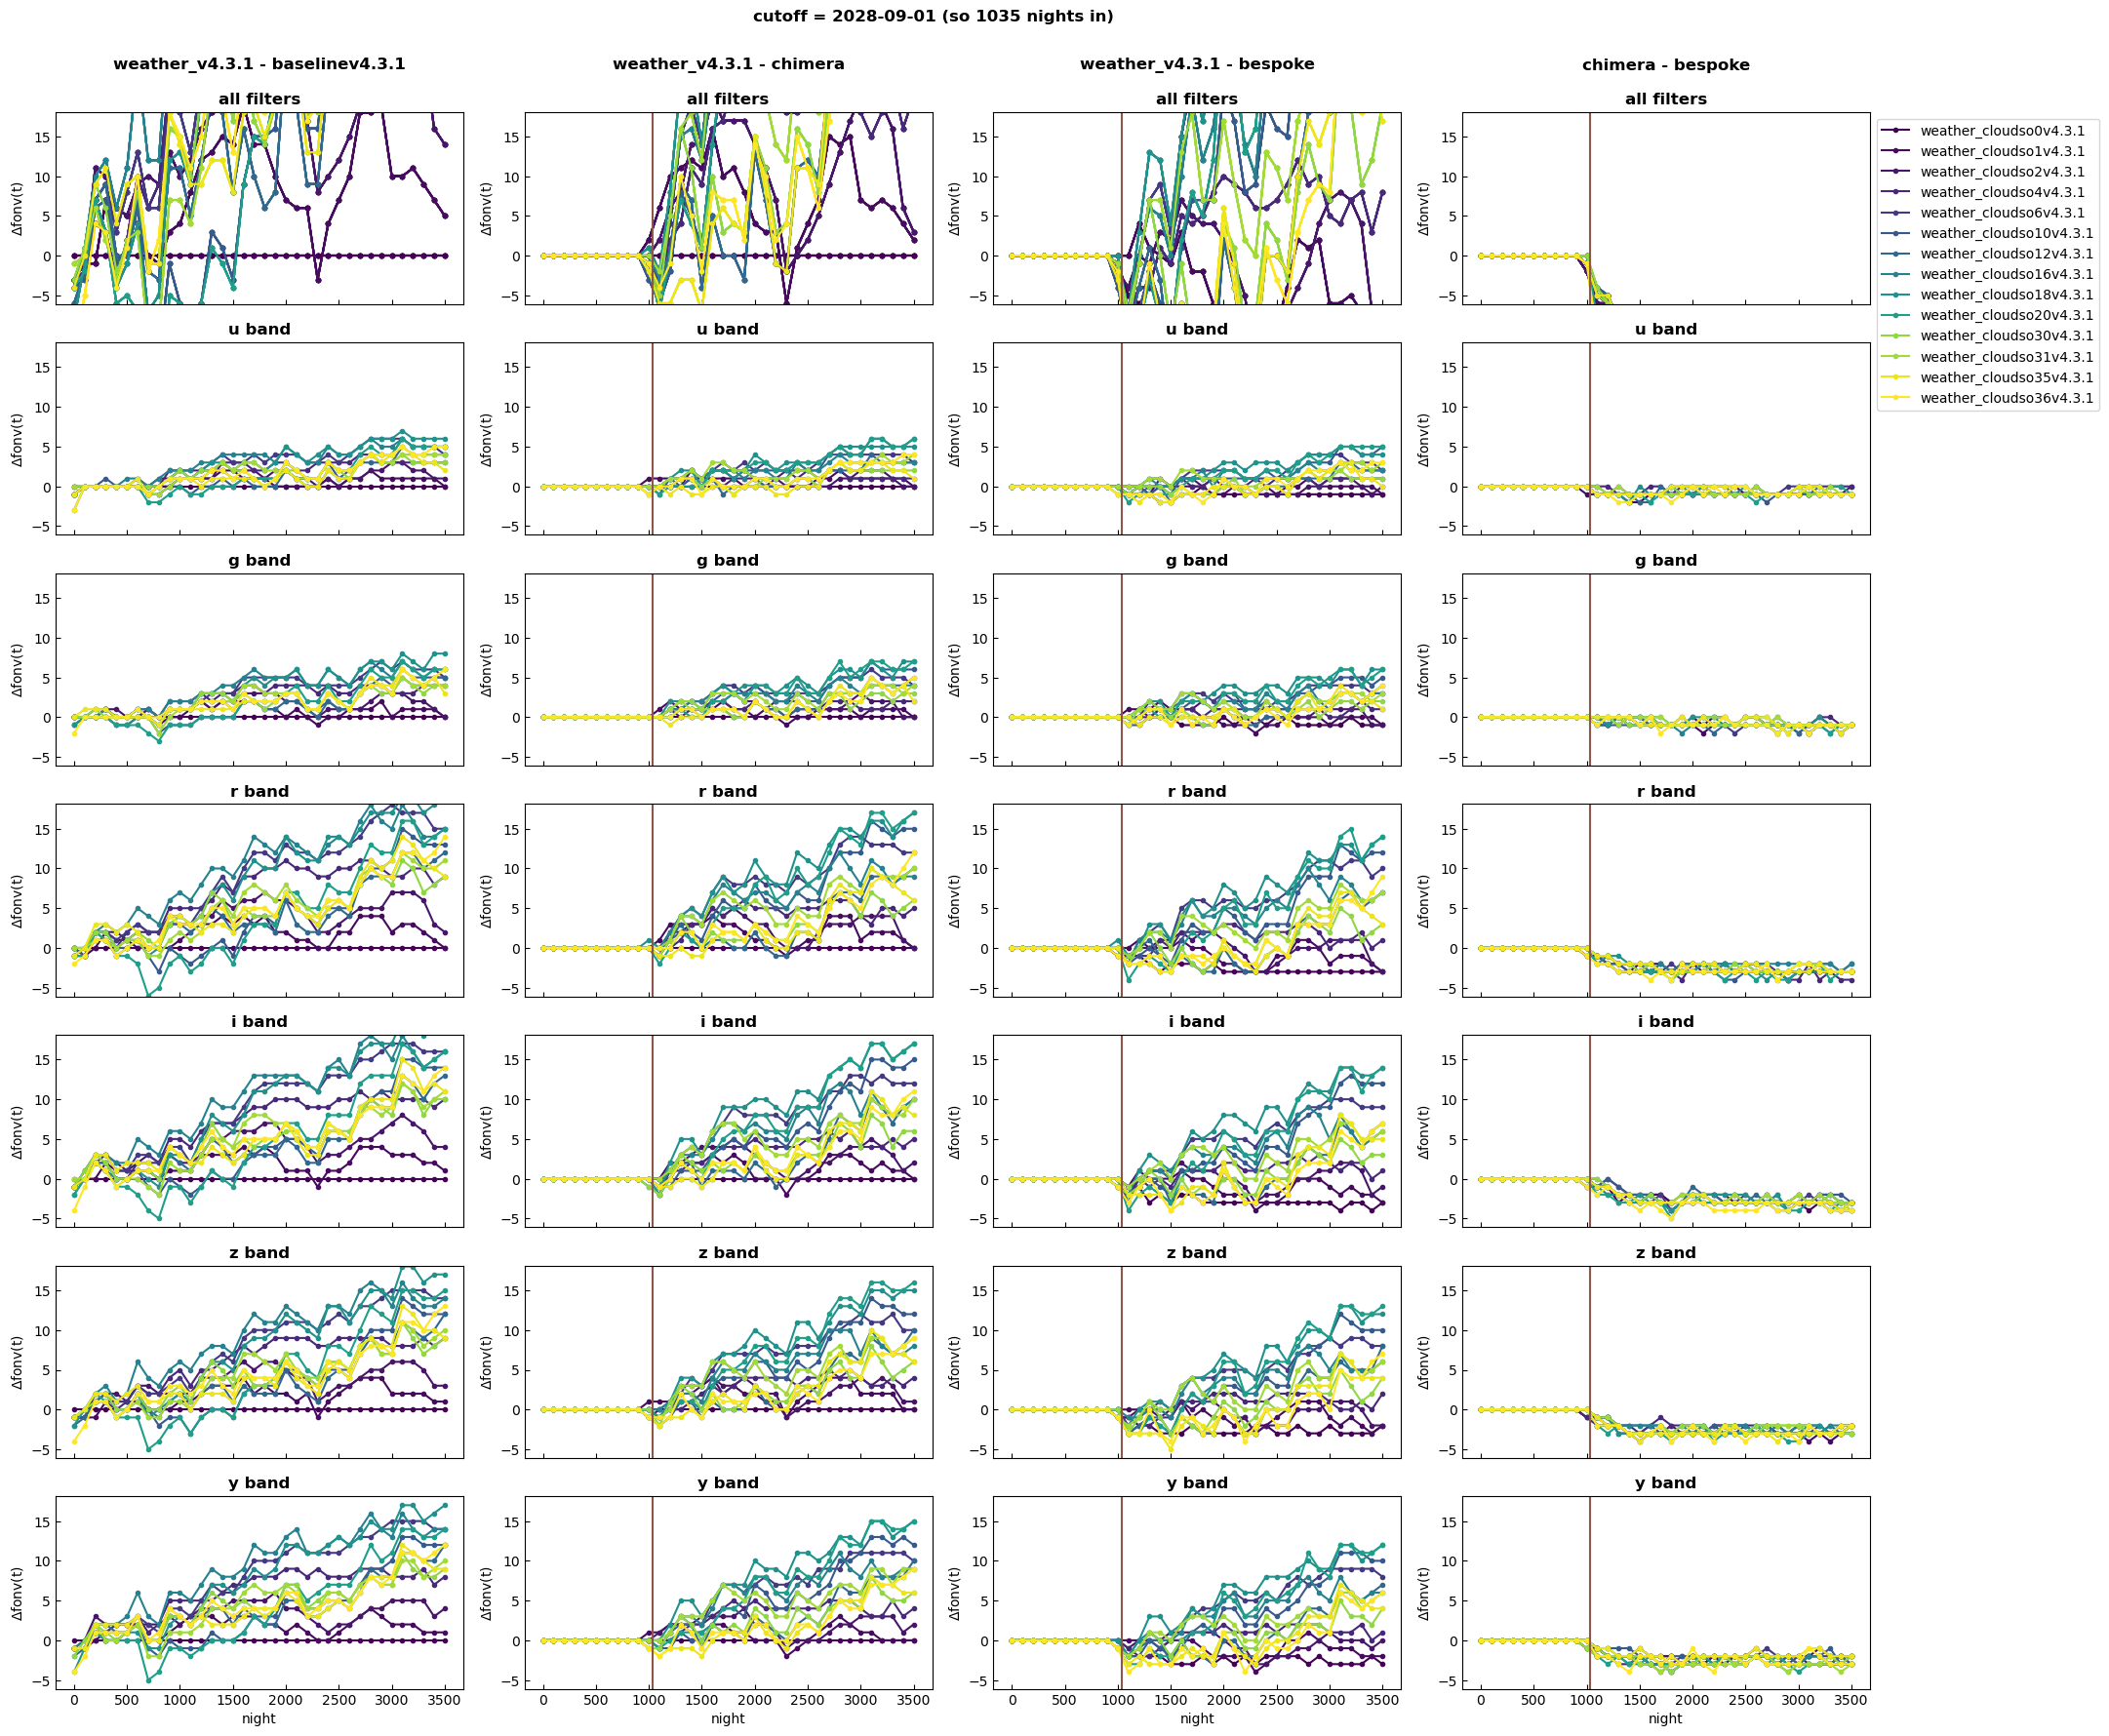

In [15]:
nrows, ncols = 7, 4

for cutoff in chimera_fonvs_time_all:
    plt.clf()
    fig, axes = plt.subplots(nrows, ncols)
    plt.subplots_adjust(hspace=0.2, wspace=0.15)
    for i, filt in enumerate(fonvs_time_per_filter):
        for j, db in enumerate(np.array(list(clouds_tag.keys()))): #[[1,5,8,10,12]]):
            if db.__contains__('baseline'):
                color = 'r'
                sym = '+'
            else:
                color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
                sym = '.'
    
            # original vs baseline
            axes[0, 0].plot(time_points[:-1], fonvs_time_all[db] - fonvs_time_all[baseline_tag], sym+'-',
                         label=db if i == 0 else None, color=color)
            axes[i+1, 0].plot(time_points[:-1], fonvs_time_per_filter[filt][db] - fonvs_time_per_filter[filt][baseline_tag],
                           sym+'-', color=color)
            # original vs chimera
            key1 = f'chimera_cutoff{cutoff}_{db}'
            axes[0, 1].plot(time_points[:-1], fonvs_time_all[db] - chimera_fonvs_time_all[cutoff][key1],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, 1].plot(time_points[:-1], fonvs_time_per_filter[filt][db] - chimera_fonvs_time_per_filter[cutoff][filt][key1],
                            sym+'-', color=color)
    
            # original vs bespoke
            key2 = f'bespoke_cutoff{cutoff}_{db}'
            axes[0, 2].plot(time_points[:-1], fonvs_time_all[db] - bespoke_fonvs_time_all[cutoff][key2],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, 2].plot(time_points[:-1], fonvs_time_per_filter[filt][db] - bespoke_fonvs_time_per_filter[cutoff][filt][key2],
                            sym+'-', color=color)

            # chimera vs bespoke
            axes[0, 3].plot(time_points[:-1], chimera_fonvs_time_all[cutoff][key1] - bespoke_fonvs_time_all[cutoff][key2],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, 3].plot(time_points[:-1], chimera_fonvs_time_per_filter[cutoff][filt][key1] - bespoke_fonvs_time_per_filter[cutoff][filt][key2],
                            sym+'-', color=color)

            if j == 0:
                axes[0, 0].set_title( f'weather_v4.3.1 - baselinev4.3.1\n\nall filters', fontweight='bold')
                axes[0, 1].set_title( f'weather_v4.3.1 - chimera\n\nall filters', fontweight='bold')
                axes[0, 2].set_title( f'weather_v4.3.1 - bespoke\n\nall filters', fontweight='bold')
                axes[0, 3].set_title( f'chimera - bespoke\n\nall filters', fontweight='bold')
    
            if j == 0:
                for col in range(ncols):
                    axes[i+1, col].set_title(f'{filt} band', fontweight='bold')
                    
    for k in range(nrows):
        ymin, ymax = axes[k, 0].get_ylim()
        for c in range(ncols):
            axes[k, c].tick_params(axis="both", direction="in")
            axes[k, c].set_ylim(ylims)
            axes[k, c].set_ylabel(r'$\Delta$fonv(t)')
            if c != 0:
                axes[k, c].axvline(cutoff_night[cutoff], ymin, ymax, ls='-', color='C5')
    
    plt.suptitle( f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)', fontweight='bold', y=0.93)
    for k in range(nrows-1):
        for c in range(ncols):
            axes[k, c].set_xticklabels([])
    
    axes[0, -1].legend(bbox_to_anchor=(1,1))
    for c in range(ncols):
        axes[-1, c].set_xlabel('night')
    
    fig.set_size_inches(6*ncols, nrows*3)
    plt.show()

ok interesting. there are some differences between chimera and bespoke simulations - lets see if we can get a sense of the scale by diving the delta in the last column with say the baseline numbers:

<Figure size 640x480 with 0 Axes>

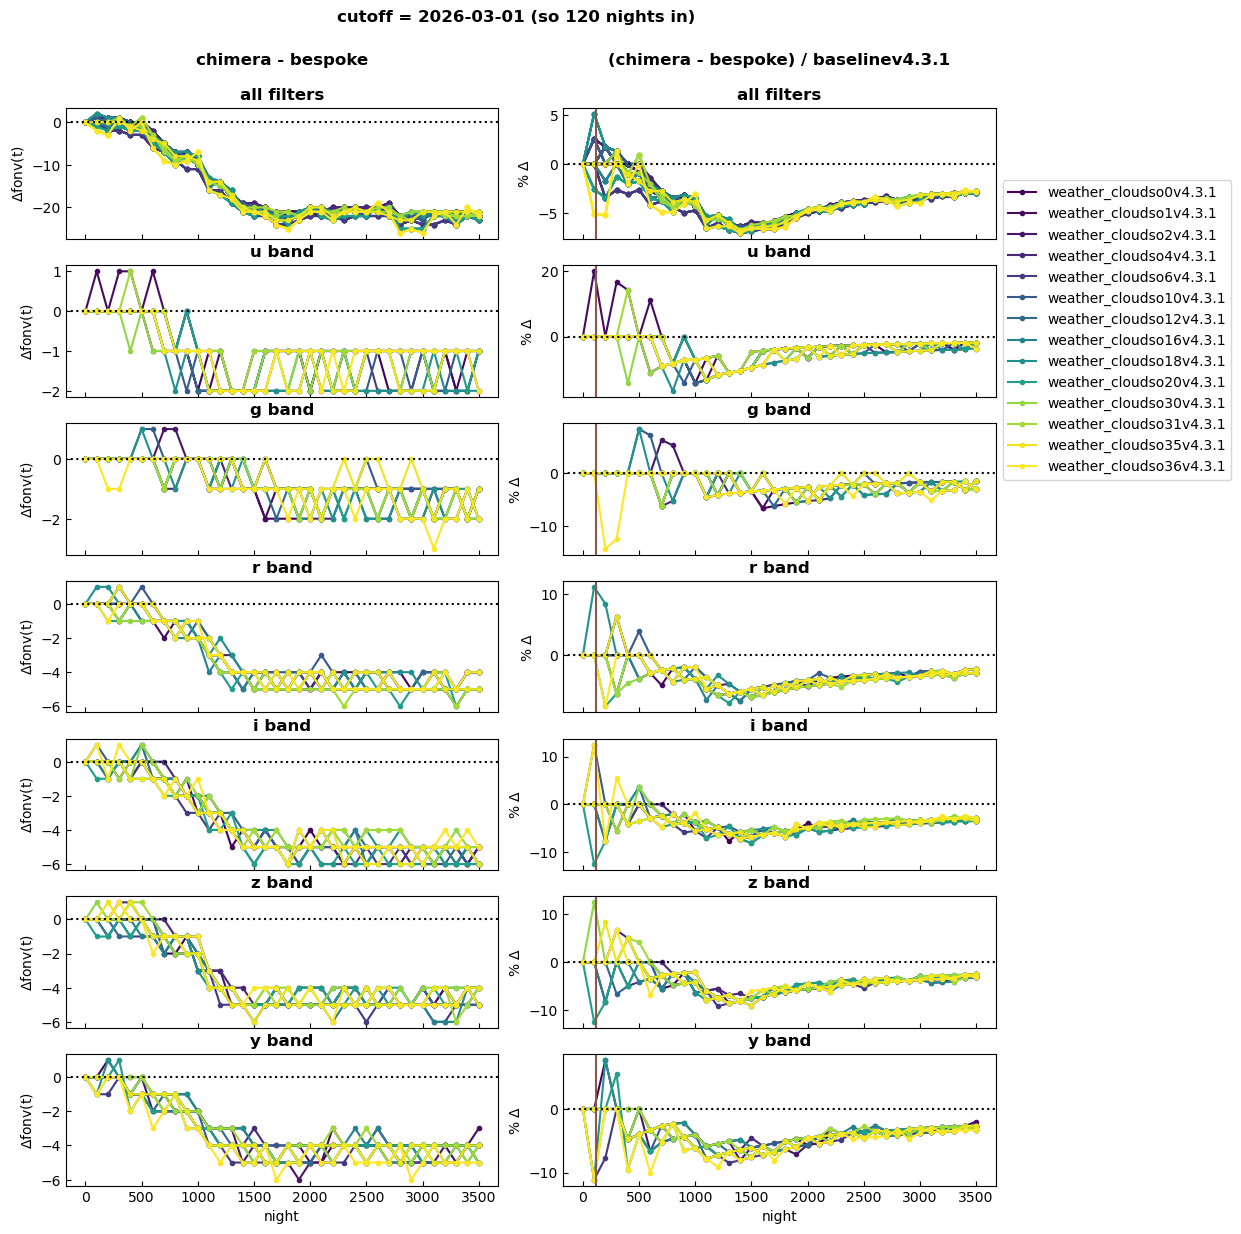

<Figure size 640x480 with 0 Axes>

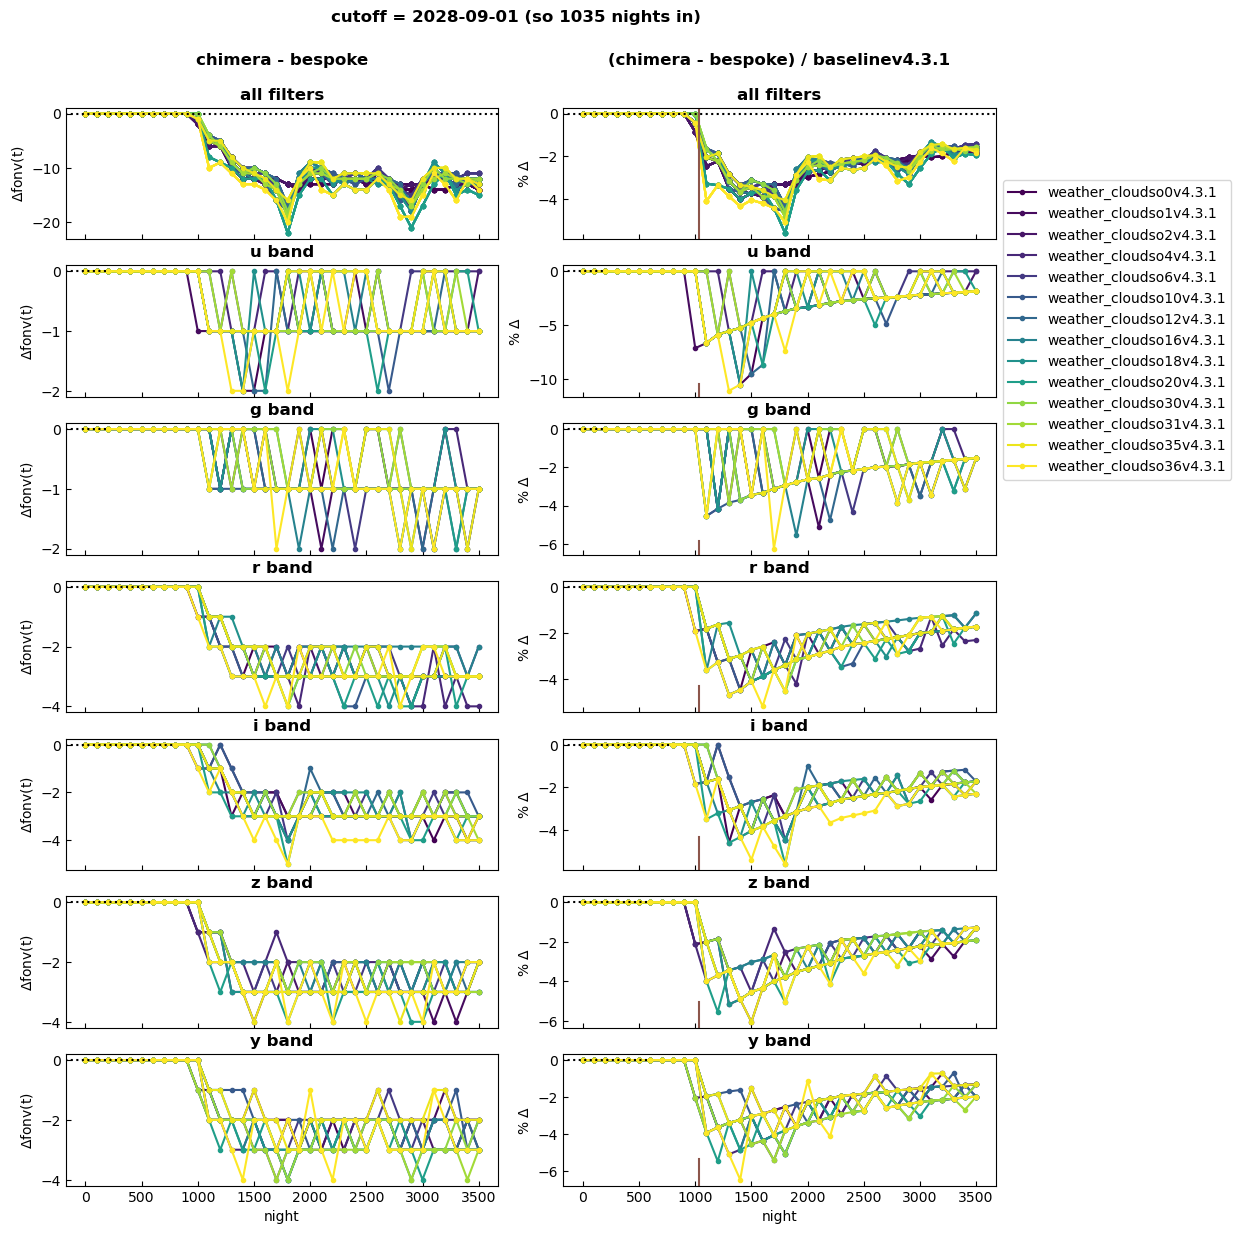

In [16]:
nrows, ncols = 7, 2

for cutoff in chimera_fonvs_time_all:
    plt.clf()
    fig, axes = plt.subplots(nrows, ncols)
    plt.subplots_adjust(hspace=0.2, wspace=0.15)
    for i, filt in enumerate(fonvs_time_per_filter):
        for j, db in enumerate(np.array(list(clouds_tag.keys()))): #[[1,5,8,10,12]]):
            if db.__contains__('baseline'):
                color = 'r'
                sym = '+'
            else:
                color = cmap( (clouds_tag[db] - min(clouds_tag.values())) / (max(clouds_tag.values()) - min(clouds_tag.values())) )
                sym = '.'
    
            # chimera vs bespoke
            key1 = f'chimera_cutoff{cutoff}_{db}'
            key2 = f'bespoke_cutoff{cutoff}_{db}'
            axes[0, 0].plot(time_points[:-1], chimera_fonvs_time_all[cutoff][key1] - bespoke_fonvs_time_all[cutoff][key2],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, 0].plot(time_points[:-1], chimera_fonvs_time_per_filter[cutoff][filt][key1] - bespoke_fonvs_time_per_filter[cutoff][filt][key2],
                            sym+'-', color=color)

            # chimera vs bespoke scaled by baseline
            axes[0, 1].plot(time_points[:-1],
                            100 * (chimera_fonvs_time_all[cutoff][key1] - bespoke_fonvs_time_all[cutoff][key2]) / fonvs_time_all[baseline_tag],
                         sym+'-', label=db if i == 0 else None, color=color)
            axes[i+1, 1].plot(time_points[:-1],
                              100 * (chimera_fonvs_time_per_filter[cutoff][filt][key1] - bespoke_fonvs_time_per_filter[cutoff][filt][key2]) / fonvs_time_per_filter[filt][baseline_tag],
                            sym+'-', color=color)

            if j == 0:
                axes[0, 0].set_title( f'chimera - bespoke\n\nall filters', fontweight='bold')
                axes[0, 1].set_title( f'(chimera - bespoke) / baselinev4.3.1\n\nall filters', fontweight='bold')
    
            if j == 0:
                for col in range(ncols):
                    axes[i+1, col].set_title(f'{filt} band', fontweight='bold')
                    
    for k in range(nrows):
        ymin, ymax = axes[k, 0].get_ylim()
        xmin, xmax = axes[k, 0].get_ylim()
        for c in range(ncols):
            axes[k, c].tick_params(axis="both", direction="in")
            axes[k, 0].set_ylabel(r'$\Delta$fonv(t)')
            axes[k, 1].set_ylabel(r'% $\Delta$ ')
            if c != 0:
                axes[k, c].axvline(cutoff_night[cutoff], ymin, ymax, ls='-', color='C5')
            axes[k, c].axhline(0, xmin, xmax, ls=':', color='k')
    
    plt.suptitle( f'cutoff = {cutoff} (so {cutoff_night[cutoff]:.0f} nights in)', fontweight='bold', y=0.95)
    for k in range(nrows-1):
        for c in range(ncols):
            axes[k, c].set_xticklabels([])
    
    axes[0, -1].legend(bbox_to_anchor=(1, 0.5))
    for c in range(ncols):
        axes[-1, c].set_xlabel('night')
    
    fig.set_size_inches(6*ncols, nrows*2)
    plt.show()

ok so we see for the earlier cutoff, max 20% difference in u-band while the rest are <~ 10%. for the later cutoff, these drop ot 10% and 5% respectively. it would be instructive to do this comparison with a cutoff date thats right before downtime (current cutoff were chosen rather randomly). also, we see the difference approaching to 0, so thats good.

overalll, while the differences are not the most dramatic, they might play a role in whether a given simulation meets the SRD requirements. it'll be instructive to look at how the two sims compare when it comes to requirements, on e.g. median visits at the end of the survey. we dont necessarily have to just look at vector metrics either.